## Imports, data, checks

In [1]:
import numpy as np
import requests
import pandas as pd
import bokeh
import datetime
import colorcet as cc
import json
import itertools
import time
from scipy import stats
import matplotlib.pyplot as plt
from datetime import datetime as dt, date
from jinja2 import Environment, FileSystemLoader
from urllib.request import urlopen
from bokeh.models import CategoricalColorMapper, NumeralTickFormatter, HoverTool, NumberFormatter, ColorBar, LinearColorMapper, BasicTicker, ColorBar
from bokeh.models import ColumnDataSource, Grid, LinearAxis, Plot, VBar, Range1d, Span, BoxAnnotation, Label, LabelSet, DataTable, DateFormatter, TableColumn, CDSView, GroupFilter
from bokeh.models.widgets import HTMLTemplateFormatter
from bokeh.plotting import output_notebook, figure
from bokeh.io import reset_output, show, output_file, save, curdoc
from bokeh.layouts import column, row, gridplot
from bokeh.palettes import *
from bokeh.transform import linear_cmap, transform
from bokeh.embed import autoload_static, components, json_item
from bokeh.resources import CDN, INLINE


The vaccine, cases, and deaths source data were relatively easy to grab diretly from the [Larimer county dashboard](https://www.larimer.org/health/communicable-disease/coronavirus-covid-19/larimer-county-positive-covid-19-numbers#/app?tab=risk) as the CSVs download through urls.

In [2]:
larimer_vac_source = pd.read_csv(
    'https://speedtest.larimer.org/covid/index.php?file=vaccinations&csv')

larimer_cases_source = pd.read_csv(
    'https://speedtest.larimer.org/covid/cases.csv', parse_dates=['ReportedDate'])

larimer_deaths_source = pd.read_csv(
    'https://larimer-county-data-lake.s3-us-west-2.amazonaws.com/Public/covid/covid_deaths.csv?t=1631890252549')


The hospitalization data was much more tricky (at least finding a simple solution was tricky) I spent several hours in webscraping research and attempts purgatory. I checked BeautifulSoup, html5lib, lxml, etc. in multiple combinations and none of them had straightforward solutions because the table for hospitalizations is actually rendered through javascript so there is nothing to scrape without actually clicking the buttons. I started down the Selenium and phantomjs path but it seemed like a nightmare. I found this lifesaving article at [Towards Data Science](https://towardsdatascience.com/data-science-skills-web-scraping-javascript-using-python-97a29738353f) which shows how to find specific XHR request urls in the browser developer tools. The requested URL for the rendered table is a pretty vanilla json and not behind any authorization so there is a pretty clean way to get to it. Praise Satan I didn't have to use Selenium.  

In [3]:
url = 'https://larimer-county-data-lake.s3-us-west-2.amazonaws.com/Public/covid/covid_patient_trend.json?t=1632506827395'

response = urlopen(url)
json_data = response.read().decode('utf-8', 'replace')

d = json.loads(json_data)
larimer_hosp_source = pd.json_normalize(d['data'])


Update 3/2022 - and they changed the hospitalization data source anyway. I was getting suspicious becuase it has been zero since late February. It looks like they were having trouble with regular daily reporting so they switched to pulling the HHS data, which aggregates admissions over the previous seven days. I'm going to add a separate df and viz starting here for the sake of preserving the previous one. larimer country also reports as per/100k, I'm going to undo that for real numbers.

In [4]:
larimer_new_hosp_source = pd.read_csv('https://speedtest.larimer.org/covid/index.php?file=hosp')

larimer_new_hosp_source.rename(columns = {'Larimer':'Hospitalizations/100k (7-day)'}, inplace = True)


larimer_new_hosp_source

date Hospitalizations/100k (7-day)
0    3/17/20                     1.6623261
1    3/18/20                     2.2164349
2    3/19/20                     2.4934892
3    3/20/20                      3.878761
4    3/21/20                      3.878761
..       ...                           ...
737   4/5/22                   1.108217432
738   4/6/22                   0.831163074
739   4/7/22                   1.108217432
740   4/8/22                   1.108217432
741   4/9/22                   1.662326148

[742 rows x 2 columns]

In [5]:
# make .csv backups of source data

larimer_vac_source.to_csv('larimer_vac_backup.csv')

larimer_cases_source.to_csv('larimer_cases_backup.csv')

larimer_deaths_source.to_csv('larimer_deaths_backup.csv')

larimer_hosp_source.to_csv('larimer_hosp_backup.csv')

larimer_new_hosp_source.to_csv('larimer_new_hosp_backup.csv')


Re-read the backup CSVs so that the notebook runs locally from this point forward.

In [6]:
larimer_vac = pd.read_csv('larimer_vac_backup.csv')

larimer_cases = pd.read_csv('larimer_cases_backup.csv')

larimer_deaths = pd.read_csv('larimer_deaths_backup.csv')

larimer_hosp = pd.read_csv('larimer_hosp_backup.csv')

larimer_new_hosp = pd.read_csv('larimer_new_hosp_backup.csv', parse_dates={'Date':[1]})

So now we have all of our dataframes

In [7]:
display(larimer_vac)

display(larimer_cases)

display(larimer_deaths)

display(larimer_hosp)

display(larimer_new_hosp)


Unnamed: 0        Date  \
0             0  12/14/2020   
1             1  12/15/2020   
2             2  12/16/2020   
3             3  12/17/2020   
4             4  12/18/2020   
..          ...         ...   
481         481    4/9/2022   
482         482   4/10/2022   
483         483   4/11/2022   
484         484   4/12/2022   
485         485   4/13/2022   

     daily number of doses received by Larimer County residents  \
0                                                   32            
1                                                   13            
2                                                  303            
3                                                  990            
4                                                 1058            
..                                                 ...            
481                                                638            
482                                                179            
483                                                603            
484                                                628            
485                                                 36            

     total number of doses recevied by residents  \
0                                             32   
1                                             45   
2                                            348   
3                                           1338   
4                                           2396   
..                                           ...   
481                                       629212   
482                                       629391   
483                                       629994   
484                                       630622   
485                                       630658   

     daily number of residents receiving first dose  \
0                                                32   
1                                                13   
2                                               303   
3                                               990   
4                                              1058   
..                                              ...   
481                                              35   
482                                              12   
483                                              22   
484                                              20   
485                                               3   

     total number of residents receiving first dose  \
0                                                32   
1                                                45   
2                                               348   
3                                              1338   
4                                              2396   
..                                              ...   
481                                          258205   
482                                          258217   
483                                          258239   
484                                          258259   
485                                          258262   

     daily number of residents vaccinated  \
0                                       1   
1                                       0   
2                                       0   
3                                       0   
4                                       2   
..                                    ...   
481                                    18   
482                                     7   
483                                    30   
484                                    24   
485                                     3   

     total number of residents vaccinated  daily number of 70+ vaccinated  \
0                                       1                             0.0   
1                                       1                             NaN   
2                                       1                             0.0   
3                              

Unnamed: 0  CaseCount ReportedDate     Sex   Age       Type  \
0               0          1   2020-03-09  Female  52.0  Confirmed   
1               1          2   2020-03-15    Male  49.0  Confirmed   
2               2          3   2020-03-17  Female  53.0  Confirmed   
3               3          4   2020-03-17  Female  94.0  Confirmed   
4               4          5   2020-03-18    Male  49.0  Confirmed   
...           ...        ...          ...     ...   ...        ...   
79718       79718      82071   2022-04-15    Male  70.0   Probable   
79719       79719      82072   2022-04-15    Male  72.0  Confirmed   
79720       79720      82073   2022-04-15    Male  78.0  Confirmed   
79721       79721      82074   2022-04-15    Male  83.0  Confirmed   
79722       79722      82075   2022-04-15  Female  85.0  Confirmed   

               City  
0         Johnstown  
1      Fort Collins  
2      Fort Collins  
3          Loveland  
4      Fort Collins  
...             ...  
79718  Fort Collins  
79719  Fort Collins  
79720  Fort Collins  
79721  Fort Collins  
79722  Fort Collins  

[79723 rows x 7 columns]

Unnamed: 0            death_id  death_date  age  gender          city  \
0             0  a0U5w00000edbfjEAA  2020-03-09   91  Female      Loveland   
1             1  a0U5w00000edbfiEAA  2020-03-13   95  Female      Loveland   
2             2  a0U5w00000edbfOEAQ  2020-03-15   90  Female      Loveland   
3             3  a0U5w00000edbfJEAQ  2020-03-25   87  Female  Fort Collins   
4             4  a0U5w00000edbfMEAQ  2020-03-25   74  Female      Loveland   
..          ...                 ...         ...  ...     ...           ...   
480         480  a0U5w00000iXBE3EAO  2022-03-04   90    Male      Loveland   
481         481  a0U5w00000iXC9lEAG  2022-03-07   99    Male      Loveland   
482         482  a0U5w00000iXBTJEA4  2022-03-16   86    Male  Fort Collins   
483         483  a0U5w00000iXHHWEA4  2022-03-18   70    Male    Wellington   
484         484  a0U5w00000iXBynEAG  2022-03-19   51    Male  Fort Collins   

    case_status  count  
0      Probable      1  
1      Probable      2  
2      Probable      3  
3     Confirmed      4  
4     Confirmed      5  
..          ...    ...  
480   Confirmed    481  
481   Confirmed    482  
482   Confirmed    483  
483   Confirmed    484  
484    Probable    485  

[485 rows x 8 columns]

Unnamed: 0                      Date  admission_count  \
0             0  2020-03-31T00:00:00.000Z              NaN   
1             1  2020-04-01T00:00:00.000Z              NaN   
2             2  2020-04-02T00:00:00.000Z              NaN   
3             3  2020-04-03T00:00:00.000Z              2.0   
4             4  2020-04-04T00:00:00.000Z              1.0   
..          ...                       ...              ...   
473         473  2022-02-18T00:00:00.000Z              1.0   
474         474  2022-02-22T00:00:00.000Z              4.0   
475         475  2022-02-23T00:00:00.000Z              2.0   
476         476  2022-02-24T00:00:00.000Z              3.0   
477         477  2022-02-25T00:00:00.000Z              NaN   

     kpi_admits_indicator  inpatient_count  kpi_patient_indicator  \
0                     NaN               47                      0   
1                     NaN               46                      0   
2                     NaN               46                      0   
3                     0.0               46                      0   
4                     0.0               42                      0   
..                    ...              ...                    ...   
473                   0.0               34                      0   
474                   0.0               32                      0   
475                   0.0               26                      0   
476                   0.0               24                      0   
477                   NaN               25                      0   

     inpatient_count_pct_change  
0                           NaN  
1                           NaN  
2                           NaN  
3                           NaN  
4                           NaN  
..                          ...  
473                  -38.181818  
474                  -25.581395  
475                  -33.333333  
476                  -40.000000  
477                  -37.500000  

[478 rows x 7 columns]

Date  Unnamed: 0 Hospitalizations/100k (7-day)
0   2020-03-17           0                     1.6623261
1   2020-03-18           1                     2.2164349
2   2020-03-19           2                     2.4934892
3   2020-03-20           3                      3.878761
4   2020-03-21           4                      3.878761
..         ...         ...                           ...
737 2022-04-05         737                   1.108217432
738 2022-04-06         738                   0.831163074
739 2022-04-07         739                   1.108217432
740 2022-04-08         740                   1.108217432
741 2022-04-09         741                   1.662326148

[742 rows x 3 columns]

This looks like pretty good start. We'll have to make all the datetimes match and the **hospitalization** and **vaccine** data are daily totals while the **death** and **case counts** data is a case log (a row for each case) so we'll have to do some grouping to get that to match, that will come later.

## Explore, clean, manipulate

In [8]:
dfs = [larimer_vac, larimer_deaths, larimer_cases, larimer_hosp, larimer_new_hosp]


def get_obj_col():
    for df in dfs:
        print(list(df.select_dtypes(['object']).columns))


get_obj_col()


['Date']
['death_id', 'death_date', 'gender', 'city', 'case_status']
['ReportedDate', 'Sex', 'Type', 'City']
['Date']
['Hospitalizations/100k (7-day)']


---
I did this and don't like it
```python
dfs = [larimer_vac, larimer_deaths, larimer_cases, larimer_hosp]
df_names = ['larimer_vac', 'larimer_deaths', 'larimer_cases', 'larimer_hosp']


def get_obj_col():
    for df in dfs:
        obj_cols.append(list(df.select_dtypes(['object']).columns))
    zip(df_names, dfs)
    
obj_cols = []
get_obj_col()
zipped_list = zip(df_names, obj_cols)
print(tuple(zipped_list)
```
---

In [9]:
print(larimer_cases.dtypes)
print(larimer_hosp.dtypes)
print(larimer_new_hosp.dtypes)


Unnamed: 0        int64
CaseCount         int64
ReportedDate     object
Sex              object
Age             float64
Type             object
City             object
dtype: object
Unnamed: 0                      int64
Date                           object
admission_count               float64
kpi_admits_indicator          float64
inpatient_count                 int64
kpi_patient_indicator           int64
inpatient_count_pct_change    float64
dtype: object
Date                             datetime64[ns]
Unnamed: 0                                int64
Hospitalizations/100k (7-day)            object
dtype: object


Convert date columns from each df to datetimes

In [10]:
larimer_vac['Date'] = pd.to_datetime(larimer_vac['Date']).dt.tz_localize(None)
larimer_deaths['Date'] = pd.to_datetime(
    larimer_deaths['death_date']).dt.tz_localize(None)
larimer_cases['Date'] = pd.to_datetime(
    larimer_cases['ReportedDate']).dt.tz_localize(None)
larimer_hosp['Date'] = pd.to_datetime(
    larimer_hosp['Date']).dt.tz_localize(None)




```pd.to_datetime``` was sufficient for most of the dfs but the hospital data was TZ aware and I wanted all of them to match so had to add the ```.dt.tz_localize(None)``` 

In retrospect I could have parsed all the dates on reading the csv with ```parse_dates=``` but I didn't know how to do that at the time. 

In [11]:
larimer_new_hosp

Date  Unnamed: 0 Hospitalizations/100k (7-day)
0   2020-03-17           0                     1.6623261
1   2020-03-18           1                     2.2164349
2   2020-03-19           2                     2.4934892
3   2020-03-20           3                      3.878761
4   2020-03-21           4                      3.878761
..         ...         ...                           ...
737 2022-04-05         737                   1.108217432
738 2022-04-06         738                   0.831163074
739 2022-04-07         739                   1.108217432
740 2022-04-08         740                   1.108217432
741 2022-04-09         741                   1.662326148

[742 rows x 3 columns]

In [12]:
def check_date_type():
    for df in dfs:
        print(list(df.select_dtypes(['datetime64']).columns))


check_date_type()

['Date']
['Date']
['Date']
['Date']
['Date']


The source randomly introduced a dumbass entry from 1970 in the first row which was propogating to all the following DFs and visualizations so I had to remove it here.

In [13]:
larimer_hosp = larimer_hosp[larimer_hosp['Date']
                            > pd.to_datetime('2020-03-30')]
larimer_hosp.head()


Unnamed: 0       Date  admission_count  kpi_admits_indicator  \
0           0 2020-03-31              NaN                   NaN   
1           1 2020-04-01              NaN                   NaN   
2           2 2020-04-02              NaN                   NaN   
3           3 2020-04-03              2.0                   0.0   
4           4 2020-04-04              1.0                   0.0   

   inpatient_count  kpi_patient_indicator  inpatient_count_pct_change  
0               47                      0                         NaN  
1               46                      0                         NaN  
2               46                      0                         NaN  
3               46                      0                         NaN  
4               42                      0                         NaN

In [14]:
# create daily cases from case log
daily_cases = larimer_cases.groupby(['Date']).count().reset_index()

display(daily_cases)
display(daily_cases.dtypes)
print(f"Total case check {daily_cases['CaseCount'].sum()}")
display(daily_cases.describe())


Date  Unnamed: 0  CaseCount  ReportedDate  Sex  Age  Type  City
0   2020-03-09           1          1             1    1    1     1     1
1   2020-03-15           1          1             1    1    1     1     1
2   2020-03-17           2          2             2    2    2     2     2
3   2020-03-18           1          1             1    1    1     1     1
4   2020-03-19           2          2             2    2    2     2     2
..         ...         ...        ...           ...  ...  ...   ...   ...
756 2022-04-11          55         55            55   55   55    55    55
757 2022-04-12          94         94            94   94   94    94    94
758 2022-04-13          73         73            73   73   73    73    73
759 2022-04-14          64         64            64   64   64    64    64
760 2022-04-15          35         35            35   35   35    35    35

[761 rows x 8 columns]

Date            datetime64[ns]
Unnamed: 0               int64
CaseCount                int64
ReportedDate             int64
Sex                      int64
Age                      int64
Type                     int64
City                     int64
dtype: object

Total case check 79723


Unnamed: 0    CaseCount  ReportedDate          Sex          Age  \
count   761.000000   761.000000    761.000000   761.000000   761.000000   
mean    104.760841   104.760841    104.760841   104.760841   104.622865   
std     152.698940   152.698940    152.698940   152.698940   152.587847   
min       1.000000     1.000000      1.000000     1.000000     1.000000   
25%      20.000000    20.000000     20.000000    20.000000    20.000000   
50%      62.000000    62.000000     62.000000    62.000000    62.000000   
75%     123.000000   123.000000    123.000000   123.000000   123.000000   
max    1213.000000  1213.000000   1213.000000  1213.000000  1213.000000   

              Type         City  
count   761.000000   761.000000  
mean    104.760841   104.760841  
std     152.698940   152.698940  
min       1.000000     1.000000  
25%      20.000000    20.000000  
50%      62.000000    62.000000  
75%     123.000000   123.000000  
max    1213.000000  1213.000000

In [15]:
# create daily deaths from death log
daily_deaths = larimer_deaths.groupby(['Date']).count().reset_index()

display(daily_deaths)
display(daily_deaths.dtypes)
print(f"Total death check {daily_deaths['count'].sum()}")
display(daily_deaths.describe())


Date  Unnamed: 0  death_id  death_date  age  gender  city  \
0   2020-03-09           1         1           1    1       1     1   
1   2020-03-13           1         1           1    1       1     1   
2   2020-03-15           1         1           1    1       1     1   
3   2020-03-25           2         2           2    2       2     2   
4   2020-03-29           2         2           2    2       2     2   
..         ...         ...       ...         ...  ...     ...   ...   
287 2022-03-04           1         1           1    1       1     1   
288 2022-03-07           1         1           1    1       1     1   
289 2022-03-16           1         1           1    1       1     1   
290 2022-03-18           1         1           1    1       1     1   
291 2022-03-19           1         1           1    1       1     1   

     case_status  count  
0              1      1  
1              1      1  
2              1      1  
3              2      2  
4              2      2  
..           ...    ...  
287            1      1  
288            1      1  
289            1      1  
290            1      1  
291            1      1  

[292 rows x 9 columns]

Date           datetime64[ns]
Unnamed: 0              int64
death_id                int64
death_date              int64
age                     int64
gender                  int64
city                    int64
case_status             int64
count                   int64
dtype: object

Total death check 485


Unnamed: 0    death_id  death_date         age      gender        city  \
count  292.000000  292.000000  292.000000  292.000000  292.000000  292.000000   
mean     1.660959    1.660959    1.660959    1.660959    1.660959    1.660959   
std      1.086365    1.086365    1.086365    1.086365    1.086365    1.086365   
min      1.000000    1.000000    1.000000    1.000000    1.000000    1.000000   
25%      1.000000    1.000000    1.000000    1.000000    1.000000    1.000000   
50%      1.000000    1.000000    1.000000    1.000000    1.000000    1.000000   
75%      2.000000    2.000000    2.000000    2.000000    2.000000    2.000000   
max      8.000000    8.000000    8.000000    8.000000    8.000000    8.000000   

       case_status       count  
count   292.000000  292.000000  
mean      1.660959    1.660959  
std       1.086365    1.086365  
min       1.000000    1.000000  
25%       1.000000    1.000000  
50%       1.000000    1.000000  
75%       2.000000    2.000000  
max       8.000000    8.000000

In [16]:
daily_cases.set_index('Date', inplace=True)

daily_deaths.set_index('Date', inplace=True)

larimer_vac.set_index('Date', inplace=True)

larimer_hosp.set_index('Date', inplace=True)

larimer_new_hosp.set_index('Date', inplace=True)


In [17]:
# daily_cases.index = pd.to_datetime(daily_cases.index)
# daily_cases = daily_cases.resample("1D").mean()
# daily_cases


**Try this**

```python
x.dt = pd.to_datetime(x.dt)
```
One-liner using mostly @ayhan's ideas while incorporating stack/unstack and fill_value

```python
x.set_index(
    ['dt', 'user']
).unstack(
    fill_value=0
).asfreq(
    'D', fill_value=0
).stack().sort_index(level=1).reset_index()
```
**or this might be better**
```python
s.asfreq('D'))
```


In [18]:
larimer_hosp['admission_count'] = larimer_hosp['admission_count'].astype(
    "Int64")
larimer_hosp


Unnamed: 0  admission_count  kpi_admits_indicator  \
Date                                                            
2020-03-31           0             <NA>                   NaN   
2020-04-01           1             <NA>                   NaN   
2020-04-02           2             <NA>                   NaN   
2020-04-03           3                2                   0.0   
2020-04-04           4                1                   0.0   
...                ...              ...                   ...   
2022-02-18         473                1                   0.0   
2022-02-22         474                4                   0.0   
2022-02-23         475                2                   0.0   
2022-02-24         476                3                   0.0   
2022-02-25         477             <NA>                   NaN   

            inpatient_count  kpi_patient_indicator  inpatient_count_pct_change  
Date                                                                            
2020-03-31               47                      0                         NaN  
2020-04-01               46                      0                         NaN  
2020-04-02               46                      0                         NaN  
2020-04-03               46                      0                         NaN  
2020-04-04               42                      0                         NaN  
...                     ...                    ...                         ...  
2022-02-18               34                      0                  -38.181818  
2022-02-22               32                      0                  -25.581395  
2022-02-23               26                      0                  -33.333333  
2022-02-24               24                      0                  -40.000000  
2022-02-25               25                      0                  -37.500000  

[478 rows x 6 columns]

In [19]:
larimer_hosp[larimer_hosp.index.duplicated()]


Unnamed: 0  admission_count  kpi_admits_indicator  \
Date                                                            
2021-12-15         428                6                   0.0   
2021-12-15         429                6                   0.0   
2021-12-15         430                6                   0.0   

            inpatient_count  kpi_patient_indicator  inpatient_count_pct_change  
Date                                                                            
2021-12-15               81                      1                    5.194805  
2021-12-15               81                      1                    8.000000  
2021-12-15               81                      1                    5.194805

This weird 'Unamed:0" column appeared when I switched to using dfs from the backup CSVs so I had to drop it in place to make the following duplicate drops work.


In [20]:
larimer_hosp.drop(['Unnamed: 0'], axis=1, inplace=True)


In [21]:
larimer_hosp.drop_duplicates(keep=False, inplace=True)


In [22]:
larimer_hosp[larimer_hosp.index.duplicated()]


Empty DataFrame
Columns: [admission_count, kpi_admits_indicator, inpatient_count, kpi_patient_indicator, inpatient_count_pct_change]
Index: []

In [23]:
larimer_new_hosp[larimer_new_hosp.index.duplicated()]

Empty DataFrame
Columns: [Unnamed: 0, Hospitalizations/100k (7-day)]
Index: []

In [24]:
larimer_new_hosp.drop(['Unnamed: 0'], axis=1, inplace=True)


In [25]:
daily_cases_filled = daily_cases.asfreq('D', fill_value=0)
daily_deaths_filled = daily_deaths.asfreq('D', fill_value=0)
larimer_vac_filled = larimer_vac.asfreq('D', fill_value=0)
larimer_hosp_filled = larimer_hosp.asfreq('D', fill_value=0)
larimer_new_hosp_filled = larimer_new_hosp.asfreq('D', fill_value=0)



## Quantify missing data

In [26]:
print(daily_cases_filled.isna().sum().sum())
print(daily_deaths_filled .isna().sum().sum())
print(larimer_vac_filled .isna().sum().sum())
print(larimer_hosp_filled.isna().sum().sum())
print(larimer_new_hosp_filled.isna().sum().sum())



0
0
25
40
0


In [27]:
larimer_hosp_filled = larimer_hosp_filled.fillna(0)
larimer_vac_filled = larimer_vac_filled.fillna(0)


In [28]:
print(daily_cases_filled.isna().sum().sum())
print(daily_deaths_filled .isna().sum().sum())
print(larimer_vac_filled .isna().sum().sum())
print(larimer_hosp_filled.isna().sum().sum())
print(larimer_new_hosp_filled.isna().sum().sum())


0
0
0
0
0


In [29]:
display(daily_cases_filled)
display(daily_deaths_filled)
display(larimer_vac_filled)
display(larimer_hosp_filled)
display(larimer_new_hosp)


Unnamed: 0  CaseCount  ReportedDate  Sex  Age  Type  City
Date                                                                 
2020-03-09           1          1             1    1    1     1     1
2020-03-10           0          0             0    0    0     0     0
2020-03-11           0          0             0    0    0     0     0
2020-03-12           0          0             0    0    0     0     0
2020-03-13           0          0             0    0    0     0     0
...                ...        ...           ...  ...  ...   ...   ...
2022-04-11          55         55            55   55   55    55    55
2022-04-12          94         94            94   94   94    94    94
2022-04-13          73         73            73   73   73    73    73
2022-04-14          64         64            64   64   64    64    64
2022-04-15          35         35            35   35   35    35    35

[768 rows x 7 columns]

Unnamed: 0  death_id  death_date  age  gender  city  case_status  \
Date                                                                           
2020-03-09           1         1           1    1       1     1            1   
2020-03-10           0         0           0    0       0     0            0   
2020-03-11           0         0           0    0       0     0            0   
2020-03-12           0         0           0    0       0     0            0   
2020-03-13           1         1           1    1       1     1            1   
...                ...       ...         ...  ...     ...   ...          ...   
2022-03-15           0         0           0    0       0     0            0   
2022-03-16           1         1           1    1       1     1            1   
2022-03-17           0         0           0    0       0     0            0   
2022-03-18           1         1           1    1       1     1            1   
2022-03-19           1         1           1    1       1     1            1   

            count  
Date               
2020-03-09      1  
2020-03-10      0  
2020-03-11      0  
2020-03-12      0  
2020-03-13      1  
...           ...  
2022-03-15      0  
2022-03-16      1  
2022-03-17      0  
2022-03-18      1  
2022-03-19      1  

[741 rows x 8 columns]

Unnamed: 0  \
Date                     
2020-12-14           0   
2020-12-15           1   
2020-12-16           2   
2020-12-17           3   
2020-12-18           4   
...                ...   
2022-04-09         481   
2022-04-10         482   
2022-04-11         483   
2022-04-12         484   
2022-04-13         485   

            daily number of doses received by Larimer County residents  \
Date                                                                     
2020-12-14                                                 32            
2020-12-15                                                 13            
2020-12-16                                                303            
2020-12-17                                                990            
2020-12-18                                               1058            
...                                                       ...            
2022-04-09                                                638            
2022-04-10                                                179            
2022-04-11                                                603            
2022-04-12                                                628            
2022-04-13                                                 36            

            total number of doses recevied by residents  \
Date                                                      
2020-12-14                                           32   
2020-12-15                                           45   
2020-12-16                                          348   
2020-12-17                                         1338   
2020-12-18                                         2396   
...                                                 ...   
2022-04-09                                       629212   
2022-04-10                                       629391   
2022-04-11                                       629994   
2022-04-12                                       630622   
2022-04-13                                       630658   

            daily number of residents receiving first dose  \
Date                                                         
2020-12-14                                              32   
2020-12-15                                              13   
2020-12-16                                             303   
2020-12-17                                             990   
2020-12-18                                            1058   
...                                                    ...   
2022-04-09                                              35   
2022-04-10                                              12   
2022-04-11                                              22   
2022-04-12                                              20   
2022-04-13                                               3   

            total number of residents receiving first dose  \
Date                                                         
2020-12-14                                              32   
2020-12-15                                              45   
2020-12-16                                             348   
2020-12-17                                            1338   
2020-12-18                                            2396   
...                                                    ...   
2022-04-09                                          258205   
2022-04-10                                          258217   
2022-04-11                                          258239   
2022-04-12                                          258259   
2022-04-13                                          258262   

            daily number of residents vaccinated  \
Date                                               
2020-12-14                                     1   
2020-12-15                                     0   
2020-12-16                                     0   
2020-12-17                                     0   
2020-12-18      

admission_count  kpi_admits_indicator  inpatient_count  \
Date                                                                 
2020-03-31                0                   0.0               47   
2020-04-01                0                   0.0                0   
2020-04-02                0                   0.0                0   
2020-04-03                2                   0.0               46   
2020-04-04                1                   0.0               42   
...                     ...                   ...              ...   
2022-02-21                0                   0.0                0   
2022-02-22                4                   0.0               32   
2022-02-23                2                   0.0               26   
2022-02-24                3                   0.0               24   
2022-02-25                0                   0.0               25   

            kpi_patient_indicator  inpatient_count_pct_change  
Date                                                           
2020-03-31                      0                    0.000000  
2020-04-01                      0                    0.000000  
2020-04-02                      0                    0.000000  
2020-04-03                      0                    0.000000  
2020-04-04                      0                    0.000000  
...                           ...                         ...  
2022-02-21                      0                    0.000000  
2022-02-22                      0                  -25.581395  
2022-02-23                      0                  -33.333333  
2022-02-24                      0                  -40.000000  
2022-02-25                      0                  -37.500000  

[697 rows x 5 columns]

Hospitalizations/100k (7-day)
Date                                    
2020-03-17                     1.6623261
2020-03-18                     2.2164349
2020-03-19                     2.4934892
2020-03-20                      3.878761
2020-03-21                      3.878761
...                                  ...
2022-04-05                   1.108217432
2022-04-06                   0.831163074
2022-04-07                   1.108217432
2022-04-08                   1.108217432
2022-04-09                   1.662326148

[742 rows x 1 columns]

In [30]:
display(len(larimer_vac_filled))
display(len(larimer_hosp_filled))
display(len(larimer_new_hosp_filled))
display(len(daily_cases_filled))
display(len(daily_deaths_filled))




486

697

754

768

741

In [31]:
# valid_entries = larimer_vac.count()
# total_rows = len(larimer_vac.index)
# missing_data = total_rows - valid_entries
# missing_data


```python
merge_ordered(df1,
              df2,
              fill_method="ffill",
              on='column',
              how='outer'
```

- [x] Experimenting with merging on 'Date' column but it's been put back as an int instead of a datetime so may need to re-type that in all the DFs
- [x] Need to rename the date column in one of the frames so they can all be merged

In [32]:
# daily_cases_filled['Date'] = pd.to_datetime(daily_cases_filled['Date']).dt.tz_localize(None)
# daily_deaths_filled['Date'] = pd.to_datetime(daily_deaths_filled['Date']).dt.tz_localize(None)
# larimer_hosp_filled['Date'] = pd.to_datetime(larimer_hosp_filled['Date']).dt.tz_localize(None)
# larimer_vac_filled['Date'] = pd.to_datetime(larimer_vac_filled['Date']).dt.tz_localize(None)


In [33]:
# merge deaths with cases

death_case = pd.merge_ordered(
    daily_deaths_filled,
    daily_cases_filled,
    fill_method=None,
    on='Date',
    how='outer')

death_case


Date  Unnamed: 0_x  death_id  death_date  age  gender  city  \
0   2020-03-09           1.0       1.0         1.0  1.0     1.0   1.0   
1   2020-03-10           0.0       0.0         0.0  0.0     0.0   0.0   
2   2020-03-11           0.0       0.0         0.0  0.0     0.0   0.0   
3   2020-03-12           0.0       0.0         0.0  0.0     0.0   0.0   
4   2020-03-13           1.0       1.0         1.0  1.0     1.0   1.0   
..         ...           ...       ...         ...  ...     ...   ...   
763 2022-04-11           NaN       NaN         NaN  NaN     NaN   NaN   
764 2022-04-12           NaN       NaN         NaN  NaN     NaN   NaN   
765 2022-04-13           NaN       NaN         NaN  NaN     NaN   NaN   
766 2022-04-14           NaN       NaN         NaN  NaN     NaN   NaN   
767 2022-04-15           NaN       NaN         NaN  NaN     NaN   NaN   

     case_status  count  Unnamed: 0_y  CaseCount  ReportedDate  Sex  Age  \
0            1.0    1.0             1          1             1    1    1   
1            0.0    0.0             0          0             0    0    0   
2            0.0    0.0             0          0             0    0    0   
3            0.0    0.0             0          0             0    0    0   
4            1.0    1.0             0          0             0    0    0   
..           ...    ...           ...        ...           ...  ...  ...   
763          NaN    NaN            55         55            55   55   55   
764          NaN    NaN            94         94            94   94   94   
765          NaN    NaN            73         73            73   73   73   
766          NaN    NaN            64         64            64   64   64   
767          NaN    NaN            35         35            35   35   35   

     Type  City  
0       1     1  
1       0     0  
2       0     0  
3       0     0  
4       0     0  
..    ...   ...  
763    55    55  
764    94    94  
765    73    73  
766    64    64  
767    35    35  

[768 rows x 16 columns]

In [34]:
# merge death/cases with hospitalizations

death_case_hosp = pd.merge_ordered(
    death_case,
    larimer_hosp_filled,
    fill_method=None,
    on='Date',
    how='outer')

death_case_hosp


Date  Unnamed: 0_x  death_id  death_date  age  gender  city  \
0   2020-03-09           1.0       1.0         1.0  1.0     1.0   1.0   
1   2020-03-10           0.0       0.0         0.0  0.0     0.0   0.0   
2   2020-03-11           0.0       0.0         0.0  0.0     0.0   0.0   
3   2020-03-12           0.0       0.0         0.0  0.0     0.0   0.0   
4   2020-03-13           1.0       1.0         1.0  1.0     1.0   1.0   
..         ...           ...       ...         ...  ...     ...   ...   
763 2022-04-11           NaN       NaN         NaN  NaN     NaN   NaN   
764 2022-04-12           NaN       NaN         NaN  NaN     NaN   NaN   
765 2022-04-13           NaN       NaN         NaN  NaN     NaN   NaN   
766 2022-04-14           NaN       NaN         NaN  NaN     NaN   NaN   
767 2022-04-15           NaN       NaN         NaN  NaN     NaN   NaN   

     case_status  count  Unnamed: 0_y  ...  ReportedDate  Sex  Age  Type  \
0            1.0    1.0             1  ...             1    1    1     1   
1            0.0    0.0             0  ...             0    0    0     0   
2            0.0    0.0             0  ...             0    0    0     0   
3            0.0    0.0             0  ...             0    0    0     0   
4            1.0    1.0             0  ...             0    0    0     0   
..           ...    ...           ...  ...           ...  ...  ...   ...   
763          NaN    NaN            55  ...            55   55   55    55   
764          NaN    NaN            94  ...            94   94   94    94   
765          NaN    NaN            73  ...            73   73   73    73   
766          NaN    NaN            64  ...            64   64   64    64   
767          NaN    NaN            35  ...            35   35   35    35   

     City  admission_count  kpi_admits_indicator  inpatient_count  \
0       1             <NA>                   NaN              NaN   
1       0             <NA>                   NaN              NaN   
2       0             <NA>                   NaN              NaN   
3       0             <NA>                   NaN              NaN   
4       0             <NA>                   NaN              NaN   
..    ...              ...                   ...              ...   
763    55             <NA>                   NaN              NaN   
764    94             <NA>                   NaN              NaN   
765    73             <NA>                   NaN              NaN   
766    64             <NA>                   NaN              NaN   
767    35             <NA>                   NaN              NaN   

     kpi_patient_indicator  inpatient_count_pct_change  
0                      NaN                         NaN  
1                      NaN                         NaN  
2                      NaN                         NaN  
3                      NaN                         NaN  
4                      NaN                         NaN  
..                     ...                         ...  
763                    NaN                         NaN  
764                    NaN                         NaN  
765                    NaN                         NaN  
766                    NaN                         NaN  
767                    NaN                         NaN  

[768 rows x 21 columns]

In [35]:
# merge death/case/hospitalizations with new hospitals data

death_case_hosp_new = pd.merge_ordered(
    death_case_hosp,
    larimer_new_hosp_filled,
    fill_method=None,
    on='Date',
    how='outer')

death_case_hosp_new

Date  Unnamed: 0_x  death_id  death_date  age  gender  city  \
0   2020-03-09           1.0       1.0         1.0  1.0     1.0   1.0   
1   2020-03-10           0.0       0.0         0.0  0.0     0.0   0.0   
2   2020-03-11           0.0       0.0         0.0  0.0     0.0   0.0   
3   2020-03-12           0.0       0.0         0.0  0.0     0.0   0.0   
4   2020-03-13           1.0       1.0         1.0  1.0     1.0   1.0   
..         ...           ...       ...         ...  ...     ...   ...   
763 2022-04-11           NaN       NaN         NaN  NaN     NaN   NaN   
764 2022-04-12           NaN       NaN         NaN  NaN     NaN   NaN   
765 2022-04-13           NaN       NaN         NaN  NaN     NaN   NaN   
766 2022-04-14           NaN       NaN         NaN  NaN     NaN   NaN   
767 2022-04-15           NaN       NaN         NaN  NaN     NaN   NaN   

     case_status  count  Unnamed: 0_y  ...  Sex  Age  Type  City  \
0            1.0    1.0             1  ...    1    1     1     1   
1            0.0    0.0             0  ...    0    0     0     0   
2            0.0    0.0             0  ...    0    0     0     0   
3            0.0    0.0             0  ...    0    0     0     0   
4            1.0    1.0             0  ...    0    0     0     0   
..           ...    ...           ...  ...  ...  ...   ...   ...   
763          NaN    NaN            55  ...   55   55    55    55   
764          NaN    NaN            94  ...   94   94    94    94   
765          NaN    NaN            73  ...   73   73    73    73   
766          NaN    NaN            64  ...   64   64    64    64   
767          NaN    NaN            35  ...   35   35    35    35   

     admission_count  kpi_admits_indicator  inpatient_count  \
0               <NA>                   NaN              NaN   
1               <NA>                   NaN              NaN   
2               <NA>                   NaN              NaN   
3               <NA>                   NaN              NaN   
4               <NA>                   NaN              NaN   
..               ...                   ...              ...   
763             <NA>                   NaN              NaN   
764             <NA>                   NaN              NaN   
765             <NA>                   NaN              NaN   
766             <NA>                   NaN              NaN   
767             <NA>                   NaN              NaN   

     kpi_patient_indicator  inpatient_count_pct_change  \
0                      NaN                         NaN   
1                      NaN                         NaN   
2                      NaN                         NaN   
3                      NaN                         NaN   
4                      NaN                         NaN   
..                     ...                         ...   
763                    NaN                         NaN   
764                    NaN                         NaN   
765                    NaN                         NaN   
766                    NaN                         NaN   
767                    NaN                         NaN   

     Hospitalizations/100k (7-day)  
0                              NaN  
1                              NaN  
2                              NaN  
3                              NaN  
4                              NaN  
..                             ...  
763                            NaN  
764                            NaN  
765                            NaN  
766                            NaN  
767                            NaN  

[768 rows x 22 columns]

In [36]:
combo_df = pd.merge_ordered(
    death_case_hosp_new,
    larimer_vac_filled,
    fill_method=None,
    on='Date',
    how='outer')

combo_df


Date  Unnamed: 0_x  death_id  death_date  age  gender  city  \
0   2020-03-09           1.0       1.0         1.0  1.0     1.0   1.0   
1   2020-03-10           0.0       0.0         0.0  0.0     0.0   0.0   
2   2020-03-11           0.0       0.0         0.0  0.0     0.0   0.0   
3   2020-03-12           0.0       0.0         0.0  0.0     0.0   0.0   
4   2020-03-13           1.0       1.0         1.0  1.0     1.0   1.0   
..         ...           ...       ...         ...  ...     ...   ...   
763 2022-04-11           NaN       NaN         NaN  NaN     NaN   NaN   
764 2022-04-12           NaN       NaN         NaN  NaN     NaN   NaN   
765 2022-04-13           NaN       NaN         NaN  NaN     NaN   NaN   
766 2022-04-14           NaN       NaN         NaN  NaN     NaN   NaN   
767 2022-04-15           NaN       NaN         NaN  NaN     NaN   NaN   

     case_status  count  Unnamed: 0_y  ...  \
0            1.0    1.0             1  ...   
1            0.0    0.0             0  ...   
2            0.0    0.0             0  ...   
3            0.0    0.0             0  ...   
4            1.0    1.0             0  ...   
..           ...    ...           ...  ...   
763          NaN    NaN            55  ...   
764          NaN    NaN            94  ...   
765          NaN    NaN            73  ...   
766          NaN    NaN            64  ...   
767          NaN    NaN            35  ...   

     daily number of Latinx residents vaccinated  \
0                                            NaN   
1                                            NaN   
2                                            NaN   
3                                            NaN   
4                                            NaN   
..                                           ...   
763                                          3.0   
764                                          3.0   
765                                          0.0   
766                                          NaN   
767                                          NaN   

     total of Latinx residents vaccinated  \
0                                     NaN   
1                                     NaN   
2                                     NaN   
3                                     NaN   
4                                     NaN   
..                                    ...   
763                               14177.0   
764                               14180.0   
765                               14180.0   
766                                   NaN   
767                                   NaN   

     daily number of White non-Latinx residents vaccinated  \
0                                                  NaN       
1                                                  NaN       
2                                                  NaN       
3                                                  NaN       
4                                                  NaN       
..                                                 ...       
763                                               22.0       
764                                               18.0       
765                                                3.0       
766                                                NaN       
767                                                NaN       

     total of White non-Latinx residents vaccinated  \
0                                               NaN   
1                                               NaN   
2                                               NaN   
3                                               NaN   
4                                               NaN   
..                                              ...   
763                                        193680.0   
764                                        193698.0   
765                                        193701.0   
766                                             NaN   
767                                             NaN   

     dai

The source data has now accidentally added a few data in 2023 instead of 2022 so now I have to do this to truncate the data frame to "today", which is probably a good idea anyway.
Well they finally fixed this so then this broke the next step if the data for today hadn't been updated yet. EDIT - Looks like they fixed it but leaving this here for reference

In [37]:
# today = pd.Timestamp.today().normalize()
# today_index = combo_df.index[combo_df['Date']==today].to_list()
# today_index = today_index[1] 
# print(today_index)
# combo_df = combo_df.truncate(before=None, after=today_index)

In [38]:
for col in combo_df.columns:
    print(col)


Date
Unnamed: 0_x
death_id
death_date
age
gender
city
case_status
count
Unnamed: 0_y
CaseCount
ReportedDate
Sex
Age
Type
City
admission_count
kpi_admits_indicator
inpatient_count
kpi_patient_indicator
inpatient_count_pct_change
Hospitalizations/100k (7-day)
Unnamed: 0
daily number of doses received by Larimer County residents
total number of doses recevied by residents
daily number of residents receiving first dose
total number of residents receiving first dose
daily number of residents vaccinated
total number of residents vaccinated
daily number of 70+ vaccinated
total number of 70+ vaccinated
daily number of 70+ at least one dose
total number of 70+ at least one dose
daily number of Latinx residents vaccinated
total of Latinx residents vaccinated
daily number of White non-Latinx residents vaccinated
total of White non-Latinx residents vaccinated
daily number of non-White non-Latinx residents vaccinated
total of non-White non-Latinx residents vaccinated
dailyUnknown
totalUnknown
daily

In [39]:
combo_df.rename(columns={'count': 'Daily Death Count',
                         'daily number of doses received by Larimer County residents': 'Daily doses',
                         'CaseCount': 'Daily Cases',
                         'admission_count': 'Daily Hospitalizations',
                         'inpatient_count': 'Total Patient Count'
                         }, inplace=True)


In [40]:
combo_df[['Date', 'Daily doses', 'Daily Cases',
          'Daily Hospitalizations', 'Total Patient Count', 'Daily Death Count', 'Hospitalizations/100k (7-day)']]


Date  Daily doses  Daily Cases  Daily Hospitalizations  \
0   2020-03-09          NaN            1                    <NA>   
1   2020-03-10          NaN            0                    <NA>   
2   2020-03-11          NaN            0                    <NA>   
3   2020-03-12          NaN            0                    <NA>   
4   2020-03-13          NaN            0                    <NA>   
..         ...          ...          ...                     ...   
763 2022-04-11        603.0           55                    <NA>   
764 2022-04-12        628.0           94                    <NA>   
765 2022-04-13         36.0           73                    <NA>   
766 2022-04-14          NaN           64                    <NA>   
767 2022-04-15          NaN           35                    <NA>   

     Total Patient Count  Daily Death Count Hospitalizations/100k (7-day)  
0                    NaN                1.0                           NaN  
1                    NaN                0.0                           NaN  
2                    NaN                0.0                           NaN  
3                    NaN                0.0                           NaN  
4                    NaN                1.0                           NaN  
..                   ...                ...                           ...  
763                  NaN                NaN                           NaN  
764                  NaN                NaN                           NaN  
765                  NaN                NaN                           NaN  
766                  NaN                NaN                           NaN  
767                  NaN                NaN                           NaN  

[768 rows x 7 columns]

In [41]:
print(combo_df.isna().sum().sum())


6507


In [42]:
combo_df = combo_df.fillna(0)
print(combo_df.isna().sum().sum())


0


In [43]:
combo_df[['Date', 'Daily doses', 'Daily Cases',
          'Daily Hospitalizations', 'Daily Death Count', 'Hospitalizations/100k (7-day)']]


Date  Daily doses  Daily Cases  Daily Hospitalizations  \
0   2020-03-09          0.0            1                       0   
1   2020-03-10          0.0            0                       0   
2   2020-03-11          0.0            0                       0   
3   2020-03-12          0.0            0                       0   
4   2020-03-13          0.0            0                       0   
..         ...          ...          ...                     ...   
763 2022-04-11        603.0           55                       0   
764 2022-04-12        628.0           94                       0   
765 2022-04-13         36.0           73                       0   
766 2022-04-14          0.0           64                       0   
767 2022-04-15          0.0           35                       0   

     Daily Death Count Hospitalizations/100k (7-day)  
0                  1.0                             0  
1                  0.0                             0  
2                  0.0                             0  
3                  0.0                             0  
4                  1.0                             0  
..                 ...                           ...  
763                0.0                             0  
764                0.0                             0  
765                0.0                             0  
766                0.0                             0  
767                0.0                             0  

[768 rows x 6 columns]

In [44]:
combo_df[['7-day avg doses',
          '7-day avg Cases',
          '7-day avg Hospitalizations']] = combo_df[['Daily doses',
                                                     'Daily Cases',
                                                     'Daily Hospitalizations']].rolling(7).mean().round(0)

combo_df[['7-Day avg Deaths']] = combo_df[['Daily Death Count']
                                          ].rolling(7).mean().round(3)

combo_df[['7-Day avg Total Patient Count']] = combo_df[['Total Patient Count']
                                          ].rolling(7).mean().round(0)                                          


combo_df[['Date',
          'Daily doses',
          '7-day avg doses',
          'Daily Cases',
          '7-day avg Cases',
          'Daily Hospitalizations',
          '7-day avg Hospitalizations',
          'Daily Death Count',
          '7-Day avg Deaths',
          'Total Patient Count',
          '7-Day avg Total Patient Count',
          'Hospitalizations/100k (7-day)']]


Date  Daily doses  7-day avg doses  Daily Cases  7-day avg Cases  \
0   2020-03-09          0.0              NaN            1              NaN   
1   2020-03-10          0.0              NaN            0              NaN   
2   2020-03-11          0.0              NaN            0              NaN   
3   2020-03-12          0.0              NaN            0              NaN   
4   2020-03-13          0.0              NaN            0              NaN   
..         ...          ...              ...          ...              ...   
763 2022-04-11        603.0            638.0           55             48.0   
764 2022-04-12        628.0            609.0           94             52.0   
765 2022-04-13         36.0            545.0           73             54.0   
766 2022-04-14          0.0            456.0           64             58.0   
767 2022-04-15          0.0            298.0           35             53.0   

     Daily Hospitalizations  7-day avg Hospitalizations  Daily Death Count  \
0                         0                         NaN                1.0   
1                         0                         NaN                0.0   
2                         0                         NaN                0.0   
3                         0                         NaN                0.0   
4                         0                         NaN                1.0   
..                      ...                         ...                ...   
763                       0                         0.0                0.0   
764                       0                         0.0                0.0   
765                       0                         0.0                0.0   
766                       0                         0.0                0.0   
767                       0                         0.0                0.0   

     7-Day avg Deaths  Total Patient Count  7-Day avg Total Patient Count  \
0                 NaN                  0.0                            NaN   
1                 NaN                  0.0                            NaN   
2                 NaN                  0.0                            NaN   
3                 NaN                  0.0                            NaN   
4                 NaN                  0.0                            NaN   
..                ...                  ...                            ...   
763               0.0                  0.0                            0.0   
764               0.0                  0.0                            0.0   
765               0.0                  0.0                            0.0   
766               0.0                  0.0                            0.0   
767               0.0                  0.0                            0.0   

    Hospitalizations/100k (7-day)  
0                               0  
1                               0  
2                               0  
3                               0  
4                               0  
..                            ...  
763                             0  
764                             0  
765                             0  
766                             0  
767                             0  

[768 rows x 12 columns]

In [45]:
print(combo_df.isna().sum().sum())


30


In [46]:
combo_df['Hospitalizations/100k (7-day)'] = pd.to_numeric(combo_df['Hospitalizations/100k (7-day)'], errors='coerce')

In [47]:
print(combo_df.isna().sum().sum())


31


In [48]:
combo_df = combo_df.fillna(0)
print(combo_df.isna().sum().sum())


0


In [49]:
combo_df['7-Day Hospitalizations'] = combo_df['Hospitalizations/100k (7-day)'].multiply((3.61/7)).astype(int)

print(combo_df['7-Day Hospitalizations'].tail(25))
display(combo_df.tail(25))

743    1
744    1
745    0
746    0
747    1
748    1
749    1
750    1
751    1
752    1
753    1
754    0
755    0
756    0
757    0
758    0
759    0
760    0
761    0
762    0
763    0
764    0
765    0
766    0
767    0
Name: 7-Day Hospitalizations, dtype: int64


Date  Unnamed: 0_x  death_id  death_date  age  gender  city  \
743 2022-03-22           0.0       0.0         0.0  0.0     0.0   0.0   
744 2022-03-23           0.0       0.0         0.0  0.0     0.0   0.0   
745 2022-03-24           0.0       0.0         0.0  0.0     0.0   0.0   
746 2022-03-25           0.0       0.0         0.0  0.0     0.0   0.0   
747 2022-03-26           0.0       0.0         0.0  0.0     0.0   0.0   
748 2022-03-27           0.0       0.0         0.0  0.0     0.0   0.0   
749 2022-03-28           0.0       0.0         0.0  0.0     0.0   0.0   
750 2022-03-29           0.0       0.0         0.0  0.0     0.0   0.0   
751 2022-03-30           0.0       0.0         0.0  0.0     0.0   0.0   
752 2022-03-31           0.0       0.0         0.0  0.0     0.0   0.0   
753 2022-04-01           0.0       0.0         0.0  0.0     0.0   0.0   
754 2022-04-02           0.0       0.0         0.0  0.0     0.0   0.0   
755 2022-04-03           0.0       0.0         0.0  0.0     0.0   0.0   
756 2022-04-04           0.0       0.0         0.0  0.0     0.0   0.0   
757 2022-04-05           0.0       0.0         0.0  0.0     0.0   0.0   
758 2022-04-06           0.0       0.0         0.0  0.0     0.0   0.0   
759 2022-04-07           0.0       0.0         0.0  0.0     0.0   0.0   
760 2022-04-08           0.0       0.0         0.0  0.0     0.0   0.0   
761 2022-04-09           0.0       0.0         0.0  0.0     0.0   0.0   
762 2022-04-10           0.0       0.0         0.0  0.0     0.0   0.0   
763 2022-04-11           0.0       0.0         0.0  0.0     0.0   0.0   
764 2022-04-12           0.0       0.0         0.0  0.0     0.0   0.0   
765 2022-04-13           0.0       0.0         0.0  0.0     0.0   0.0   
766 2022-04-14           0.0       0.0         0.0  0.0     0.0   0.0   
767 2022-04-15           0.0       0.0         0.0  0.0     0.0   0.0   

     case_status  Daily Death Count  Unnamed: 0_y  ...  dailyUnknown  \
743          0.0                0.0            39  ...           2.0   
744          0.0                0.0            37  ...           2.0   
745          0.0                0.0            32  ...           1.0   
746          0.0                0.0            31  ...           4.0   
747          0.0                0.0            20  ...           0.0   
748          0.0                0.0            14  ...           1.0   
749          0.0                0.0            38  ...           0.0   
750          0.0                0.0            50  ...           4.0   
751          0.0                0.0            28  ...           1.0   
752          0.0                0.0            40  ...           3.0   
753          0.0                0.0            45  ...           4.0   
754          0.0                0.0            31  ...           3.0   
755          0.0                0.0            10  ...           0.0   
756          0.0                0.0            64  ...           0.0   
757          0.0                0.0            69  ...           3.0   
758          0.0                0.0            56  ...           2.0   
759          0.0                0.0            40  ...           4.0   
760          0.0                0.0            70  ...           2.0   
761          0.0                0.0            33  ...           1.0   
762          0.0                0.0            14  ...           0.0   
763          0.0                0.0            55  ...           3.0   
764          0.0                0.0            94  ...           1.0   
765          0.0                0.0            73  ...           0.0   
766          0.0                0.0            64  ...           0.0   
767          0.0                0.0            35  ...           0.0   

     totalUnknown  daily_additional_doses  total_additional_doses  \
743        8768.0                   121.0                135644.0   
744        8770.0                    69.0                135713.0   
745        8771.0              

In [50]:
# Make backup of final combo df
combo_df.to_csv('combo_df_backup.csv')
combo_df


Date  Unnamed: 0_x  death_id  death_date  age  gender  city  \
0   2020-03-09           1.0       1.0         1.0  1.0     1.0   1.0   
1   2020-03-10           0.0       0.0         0.0  0.0     0.0   0.0   
2   2020-03-11           0.0       0.0         0.0  0.0     0.0   0.0   
3   2020-03-12           0.0       0.0         0.0  0.0     0.0   0.0   
4   2020-03-13           1.0       1.0         1.0  1.0     1.0   1.0   
..         ...           ...       ...         ...  ...     ...   ...   
763 2022-04-11           0.0       0.0         0.0  0.0     0.0   0.0   
764 2022-04-12           0.0       0.0         0.0  0.0     0.0   0.0   
765 2022-04-13           0.0       0.0         0.0  0.0     0.0   0.0   
766 2022-04-14           0.0       0.0         0.0  0.0     0.0   0.0   
767 2022-04-15           0.0       0.0         0.0  0.0     0.0   0.0   

     case_status  Daily Death Count  Unnamed: 0_y  ...  dailyUnknown  \
0            1.0                1.0             1  ...           0.0   
1            0.0                0.0             0  ...           0.0   
2            0.0                0.0             0  ...           0.0   
3            0.0                0.0             0  ...           0.0   
4            1.0                1.0             0  ...           0.0   
..           ...                ...           ...  ...           ...   
763          0.0                0.0            55  ...           3.0   
764          0.0                0.0            94  ...           1.0   
765          0.0                0.0            73  ...           0.0   
766          0.0                0.0            64  ...           0.0   
767          0.0                0.0            35  ...           0.0   

     totalUnknown  daily_additional_doses  total_additional_doses  \
0             0.0                     0.0                     0.0   
1             0.0                     0.0                     0.0   
2             0.0                     0.0                     0.0   
3             0.0                     0.0                     0.0   
4             0.0                     0.0                     0.0   
..            ...                     ...                     ...   
763        8806.0                   554.0                143042.0   
764        8807.0                   585.0                143627.0   
765        8807.0                    31.0                143658.0   
766           0.0                     0.0                     0.0   
767           0.0                     0.0                     0.0   

     7-day avg doses  7-day avg Cases  7-day avg Hospitalizations  \
0                0.0              0.0                         0.0   
1                0.0              0.0                         0.0   
2                0.0              0.0                         0.0   
3                0.0              0.0                         0.0   
4                0.0              0.0                         0.0   
..               ...              ...                         ...   
763            638.0             48.0                         0.0   
764            609.0             52.0                         0.0   
765            545.0             54.0                         0.0   
766            456.0             58.0                         0.0   
767            298.0             53.0                         0.0   

     7-Day avg Deaths  7-Day avg Total Patient Count  7-Day Hospitalizations  
0                 0.0                            0.0                       0  
1                 0.0                            0.0                       0  
2                 0.0                            0.0                       0  
3                 0.0                            0.0                       0  
4                 0.0                            0.0                       0  
..                ...                            ...                     ...  
763               0.0                            0.0     

In [51]:
combo_df[['Date',
          'Daily doses',
          '7-day avg doses',
          'Daily Cases',
          '7-day avg Cases',
          'Daily Hospitalizations',
          '7-day avg Hospitalizations',
          'Daily Death Count',
          '7-Day avg Deaths',
          'Total Patient Count',
          '7-Day Hospitalizations']]


Date  Daily doses  7-day avg doses  Daily Cases  7-day avg Cases  \
0   2020-03-09          0.0              0.0            1              0.0   
1   2020-03-10          0.0              0.0            0              0.0   
2   2020-03-11          0.0              0.0            0              0.0   
3   2020-03-12          0.0              0.0            0              0.0   
4   2020-03-13          0.0              0.0            0              0.0   
..         ...          ...              ...          ...              ...   
763 2022-04-11        603.0            638.0           55             48.0   
764 2022-04-12        628.0            609.0           94             52.0   
765 2022-04-13         36.0            545.0           73             54.0   
766 2022-04-14          0.0            456.0           64             58.0   
767 2022-04-15          0.0            298.0           35             53.0   

     Daily Hospitalizations  7-day avg Hospitalizations  Daily Death Count  \
0                         0                         0.0                1.0   
1                         0                         0.0                0.0   
2                         0                         0.0                0.0   
3                         0                         0.0                0.0   
4                         0                         0.0                1.0   
..                      ...                         ...                ...   
763                       0                         0.0                0.0   
764                       0                         0.0                0.0   
765                       0                         0.0                0.0   
766                       0                         0.0                0.0   
767                       0                         0.0                0.0   

     7-Day avg Deaths  Total Patient Count  7-Day Hospitalizations  
0                 0.0                  0.0                       0  
1                 0.0                  0.0                       0  
2                 0.0                  0.0                       0  
3                 0.0                  0.0                       0  
4                 0.0                  0.0                       0  
..                ...                  ...                     ...  
763               0.0                  0.0                       0  
764               0.0                  0.0                       0  
765               0.0                  0.0                       0  
766               0.0                  0.0                       0  
767               0.0                  0.0                       0  

[768 rows x 11 columns]

In [52]:
combo_df['Vaccine Availability'] = np.where(combo_df['Date']>'2020-12-14', 'Post Vaccine', 'Pre-Vaccine')

combo_df['Vaccine Availability']


0       Pre-Vaccine
1       Pre-Vaccine
2       Pre-Vaccine
3       Pre-Vaccine
4       Pre-Vaccine
           ...     
763    Post Vaccine
764    Post Vaccine
765    Post Vaccine
766    Post Vaccine
767    Post Vaccine
Name: Vaccine Availability, Length: 768, dtype: object

## Visualize

### Hover example

```python
hover = HoverTool()
hover.tooltips = [
    ("Totals", "@TONS_HE High Explosive / @TONS_IC Incendiary / @TONS_FRAG Fragmentation")]

hover.mode = 'vline'

p.add_tools(hover)

show(p)
```


### Color mapper

```python
#Use the field name of the column source
mapper = linear_cmap(field_name='y', palette=Spectral6 ,low=min(y) ,high=max(y))

source = ColumnDataSource(dict(x=x,y=y))

p = figure(width=300, height=300, title="Linear Color Map Based on Y")

p.circle(x='x', y='y', line_color=mapper,color=mapper, fill_alpha=1, size=12, source=source)

color_bar = ColorBar(color_mapper=mapper['transform'], width=8)

p.add_layout(color_bar, 'right')
```


### Saving Pattern

```python
output_notebook()

plot = figure(plot_width=600, plot_height=600, tools='pan,box_zoom,reset')

plot.square(x=[1, 2, 4, 8, 10], y=[6, 2, 18, 4, 9], size=20)


show(plot)
output_file('bokeh_save.html')
save(plot)
reset_output()
```

In [53]:
# Print the color palette we're using then flip it over turn it and reverse it and make sure it worked
print(RdBu[11])
BuRd = RdBu[11][::-1]
print(BuRd)


('#053061', '#2166ac', '#4393c3', '#92c5de', '#d1e5f0', '#f7f7f7', '#fddbc7', '#f4a582', '#d6604d', '#b2182b', '#67001f')
('#67001f', '#b2182b', '#d6604d', '#f4a582', '#fddbc7', '#f7f7f7', '#d1e5f0', '#92c5de', '#4393c3', '#2166ac', '#053061')


In [54]:
# Get and initialize the html template we are using to save our figures
env = Environment(loader=FileSystemLoader('templates'))
fig_template = env.get_template('fig_template.html')


In [55]:
# Set some annotations variables that can be used in all plots

def add_annos(p):
    vac_start = datetime.date(2020, 12, 14)
    vac_line = Span(location=vac_start,
            dimension='height',
            line_dash='dashed')
    vac_label = Label(x=vac_start, 
                text_font_size='11px',
                y=450, 
                x_offset=5, 
                y_offset=5, 
                y_units='screen', 
                text='Vaccines\nAvailable',
                name='vac_label')
    delta_start = datetime.date(2021, 6, 6)               
    delta_end = datetime.date(2021, 12, 19)
    delta_box = BoxAnnotation(left=delta_start,
                        right=delta_end,
                        fill_color='#a8559f',
                        fill_alpha=0.1,
                        bottom=0,
                        bottom_units='data',
                        # hatch_pattern = '"',
                        # hatch_weight=0.5,
                        # hatch_alpha=0.5,
                        )
    delta_label = Label(x=delta_start,
                y=420,
                text_font_size='11px',
                x_offset=5,                         
                y_offset=5, 
                y_units='screen', 
                text='Delta',
                name='delta_label')                     
    omi_start = datetime.date(2021, 12, 19)               
    omi_end = datetime.date(2022, 3, 21)
    omi_box = BoxAnnotation(left=omi_start,
                    right=omi_end,
                    bottom=0,
                    fill_color='#2f4976',
                    fill_alpha=0.2,
                    bottom_units='data',
                #     hatch_pattern = ",",
                #     hatch_weight=0.5,
                #     hatch_alpha=0.8,
                #     hatch_scale=10,
                #     hatch_color="#5884a6",
                    )
    omi_label = Label(x=omi_start,
                y=400,
                text_font_size='11px',
                x_offset=5,                         
                y_offset=5, 
                y_units='screen', 
                text='Omicron',
                name='omi_label')    
    ba2_start = datetime.date(2022, 3, 22)               
    ba2_end = date.today()
    ba2_box = BoxAnnotation(left=ba2_start,
                    right=ba2_end,
                    bottom=0,
                    fill_color='#a8559f',
                    fill_alpha=0.2,
                    bottom_units='data',
                #     hatch_pattern = ",",
                #     hatch_weight=0.5,
                #     hatch_alpha=0.8,
                #     hatch_scale=10,
                #     hatch_color="#5884a6",
                    )
    ba2_label = Label(x=ba2_start,
                y=400,
                text_font_size='11px',
                x_offset=5,                         
                y_offset=5, 
                y_units='screen', 
                text='BA2',
                name='ba2_label') 
    layouts = [vac_line, vac_label, delta_box, delta_label, omi_box, omi_label, ba2_box, ba2_label]
    
    for l in layouts:
      p.add_layout(l)                              

In [56]:
def style_plot(p):
    p.background_fill_color = '#d7e4e9'
    p.border_fill_color = '#d7e4e9'
    p.background_fill_alpha = 1
    p.grid.grid_line_color = '#5884a6'

def add_legend(p):
   p.legend.location = 'top_left'
   p.legend.click_policy="mute" 


In [57]:
output_notebook()

lar_vac_data = ColumnDataSource(combo_df)


TOOLS = 'pan, wheel_zoom, box_zoom, reset, save'

TOOLTIPS = [('Date', '@Date{ %F}'),
            ('Daily Doses', '@{Daily doses}'),
            ('7-day avg doses', '@{7-day avg doses}')]

# Filtered view didn't work
# view = CDSView(source=lar_vac_data, filters=[GroupFilter(column_name='Vaccine Availability', group='Pre-Vaccine')])

mapper = linear_cmap(field_name='Daily doses',
                     palette=cc.CET_L17, low=(None), high=(None))

daily_vac_figure_combo = figure(title='Daily Vaccinations',
                                x_axis_type="datetime",
                                height=550,
                                sizing_mode='stretch_width',
                                tools=TOOLS)


daily_vac_figure_combo.vbar(x='Date',
                            top='Daily doses',
                            width=datetime.timedelta(days=0.5),
                            alpha=1,
                            color=mapper,
                            legend_label='Daily Doses',
                            source=lar_vac_data)

line = daily_vac_figure_combo.line(x='Date',
                                   y='7-day avg doses',
                                   line_width=2,
                                   color='#000000',
                                   legend_label='7-Day avg Doses',
                                   source=lar_vac_data)


style_plot(daily_vac_figure_combo)
add_annos(daily_vac_figure_combo)
add_legend(daily_vac_figure_combo)

# daily_vac_figure_combo.add_layout(vac_line)
# daily_vac_figure_combo.add_layout(delta_box)
# daily_vac_figure_combo.add_layout(omi_box)
# daily_vac_figure_combo.add_layout(vac_label)
# daily_vac_figure_combo.add_layout(delta_label)

vac_hover = HoverTool()
vac_hover.tooltips = TOOLTIPS
vac_hover.mode = 'vline'
vac_hover.formatters = {'@Date': 'datetime'}
vac_hover.renderers = [line]

daily_vac_figure_combo.add_tools(vac_hover)


#daily_vac_figure_combo.add_tools(HoverTool(tooltips=[("Date", "@x"),('Doses','@top')]))


Loading BokehJS ...

In [58]:
show(daily_vac_figure_combo)
save(daily_vac_figure_combo, title='Vaccination Plot',
     filename='larimer_fig_docs/vac_mod.html', template=fig_template)
reset_output()


/Users/cstephenson/opt/anaconda3/envs/updated_jupyter/lib/python3.9/site-packages/bokeh/io/saving.py:142: UserWarning: save() called but no resources were supplied and output_file(...) was never called, defaulting to resources.CDN
  warn("save() called but no resources were supplied and output_file(...) was never called, defaulting to resources.CDN")


This was my attempt at a js solution

```python
js, vac_tag = autoload_static(daily_vac_figure_combo, CDN, "fig_embeds/vac.js") # path doesn't matter; won't be using
    
file = open('fig_embeds/vac.js', 'w') # filename doesn't matter either, use whatever you like
file.write(js)
file.close()
print(vac_tag)
```

In [59]:

output_notebook()

lar_vac_data = ColumnDataSource(combo_df)


TOOLS = 'pan, wheel_zoom, box_zoom, reset, save'

TOOLTIPS = [('Date', '@Date{ %F}'),
            ('Daily Cases', '@{Daily Cases}'),
            ('7-day avg Cases', '@{7-day avg Cases}')]


mapper = linear_cmap(field_name='Daily Cases', palette=cc.CET_L17, low=(None), high=(None))

daily_case_figure_combo = figure(title='Daily Cases',
                                 x_axis_type="datetime",
                                 height=550,
                                 sizing_mode='stretch_width',
                                 tools=TOOLS)


daily_case_figure_combo.vbar(x='Date',
                             top='Daily Cases',
                             width=datetime.timedelta(days=0.5),
                             alpha=1,
                             color=mapper,
                             legend_label='Daily Cases',
                             source=lar_vac_data)

                            
line = daily_case_figure_combo.line(x='Date',
                                    y='7-day avg Cases',
                                    line_width=2,
                                    color='#000000',
                                    legend_label='7-day avg Cases',
                                    source=lar_vac_data)


style_plot(daily_case_figure_combo)
add_annos(daily_case_figure_combo)
add_legend(daily_case_figure_combo)

case_hover = HoverTool()
case_hover.tooltips = TOOLTIPS
case_hover.mode = 'vline'
case_hover.formatters = {'@Date': 'datetime'}
case_hover.renderers = [line]


daily_case_figure_combo.add_tools(case_hover)


Loading BokehJS ...

In [60]:
show(daily_case_figure_combo)
save(daily_case_figure_combo, title='Daily Case Plot',
     filename='larimer_fig_docs/case_mod.html', template=fig_template)
reset_output()


In [61]:
output_notebook()

lar_vac_data = ColumnDataSource(combo_df)

TOOLS = 'pan, wheel_zoom, box_zoom, reset, save'

TOOLTIPS = [('Date', '@Date{ %F}'),
            ('Daily Hospitalizations', '@{Daily Hospitalizations}'),
            ('7-day avg Hospitalizations', '@{7-day avg Hospitalizations}')]


mapper = linear_cmap(field_name='Daily Hospitalizations',
                     palette=list(reversed(cc.fire)), low=(None), high=(None))

daily_hosp_figure_combo = figure(title='Daily Hospitalizations',
                                 x_axis_type="datetime",
                                 height=550,
                                 sizing_mode='stretch_width',
                                 tools=TOOLS)


daily_hosp_figure_combo.vbar(x='Date',
                             top='Daily Hospitalizations',
                             width=datetime.timedelta(days=0.5),
                             alpha=0.5,
                             color=mapper,
                             legend_label='Daily Hospitalizations',
                             source=lar_vac_data)


line = daily_hosp_figure_combo.line(x='Date',
                                    y='7-day avg Hospitalizations',
                                    line_width=2,
                                    color='#000000',
                                    legend_label='7-day avg Hospitalizations',
                                    source=lar_vac_data)

add_annos(daily_hosp_figure_combo)
style_plot(daily_hosp_figure_combo)
add_legend(daily_hosp_figure_combo)

hosp_hover = HoverTool()

hosp_hover.tooltips = TOOLTIPS

hosp_hover.mode = 'vline'

hosp_hover.formatters = {'@Date': 'datetime'}

hosp_hover.renderers = [line]

daily_hosp_figure_combo.add_tools(hosp_hover)


Loading BokehJS ...

In [62]:
show(daily_hosp_figure_combo)
save(daily_hosp_figure_combo, title='Hospitalization Plot',
     filename='larimer_fig_docs/hosp_mod.html', template=fig_template)
reset_output()


In [63]:
# hospital data comparison fig

output_notebook()

lar_vac_data = ColumnDataSource(combo_df)

TOOLS = 'pan, wheel_zoom, box_zoom, reset, save'

TOOLTIPS = [('Date', '@Date{ %F}'),
            ('Daily Hospitalizations', '@{Daily Hospitalizations}'),
            ('7-day avg Hospitalizations', '@{7-day avg Hospitalizations}'),
            ('New hosp data', '@{7-Day Hospitalizations}')]


mapper = linear_cmap(field_name='New Hosp Data Comparison',
                     palette=list(reversed(cc.fire)), low=(None), high=(None))

hosp_comp = figure(title='Daily Hospitalizations',
                                 x_axis_type="datetime",
                                 height=550,
                                 sizing_mode='stretch_width',
                                 tools=TOOLS)


# hosp_comp.vbar(x='Date',
#                              top='Daily Hospitalizations',
#                              width=datetime.timedelta(days=0.5),
#                              alpha=0.5,
#                              color=mapper,
#                              source=lar_vac_data)


line = hosp_comp.line(x='Date',
                                    y='7-day avg Hospitalizations',
                                    line_width=2,
                                    color='#000000',
                                    line_alpha=0.6,
                                    source=lar_vac_data)

line2 = hosp_comp.line(x='Date',
                                    y='7-Day Hospitalizations',
                                    line_width=2,
                                    line_dash='dashed',
                                    color='#000000',
                                    source=lar_vac_data)                                    

add_annos(hosp_comp)
style_plot(hosp_comp)

hosp_hover = HoverTool()

hosp_hover.tooltips = TOOLTIPS

hosp_hover.mode = 'vline'

hosp_hover.formatters = {'@Date': 'datetime'}

hosp_hover.renderers = [line]

hosp_comp.add_tools(hosp_hover)

show(hosp_comp)
reset_output()

Loading BokehJS ...

In [64]:
# fig from new hosp data

output_notebook()

lar_vac_data = ColumnDataSource(combo_df)

TOOLS = 'pan, wheel_zoom, box_zoom, reset, save'

TOOLTIPS = [('Date', '@Date{ %F}'),
            ('7-Day Hospitalizations', '@{7-Day Hospitalizations}')]


mapper = linear_cmap(field_name='7-Day Hospitalizations',
                     palette=cc.CET_L17, low=(None), high=(None))

new_hosp_fig = figure(title='Rolling 7-day average Hospitalizations',
                                 x_axis_type="datetime",
                                 height=550,
                                 sizing_mode='stretch_width',
                                 tools=TOOLS)


new_hosp_fig.vbar(x='Date',
                             top='7-Day Hospitalizations',
                             width=datetime.timedelta(days=0.5),
                             alpha=1,
                             color=mapper,
                             source=lar_vac_data)



line = new_hosp_fig.line(x='Date',
                                    y='7-Day Hospitalizations',
                                    line_width=1,
                                    color='#000000',
                                    source=lar_vac_data)                                    

add_annos(new_hosp_fig)
style_plot(new_hosp_fig)

new_hosp_hover = HoverTool()

new_hosp_hover.tooltips = TOOLTIPS

new_hosp_hover.mode = 'vline'

new_hosp_hover.formatters = {'@Date': 'datetime'}

new_hosp_hover.renderers = [line]

new_hosp_fig.add_tools(new_hosp_hover)

show(new_hosp_fig)
reset_output()

Loading BokehJS ...

In [65]:
output_notebook()

lar_vac_data = ColumnDataSource(combo_df)


TOOLS = 'pan, wheel_zoom, box_zoom, reset, save'

TOOLTIPS = [('Date', '@Date{ %F}'),
            ('7-Day avg Total Patient Count', '@{7-Day avg Total Patient Count}')]


mapper = linear_cmap(field_name='7-Day avg Total Patient Count', palette=cc.CET_L17, low=(None), high=(None))

total_patient_figure = figure(title='7-Day avg Total Patient Count',
                              x_axis_type="datetime",
                              height=550,
                              sizing_mode='stretch_width',
                              tools=TOOLS)


total_patient_figure.vbar(x='Date',
                          top='Total Patient Count',
                          width=datetime.timedelta(days=0.5),
                          alpha=1,
                          color=mapper,
                          legend_label='Total Patient Count',
                          source=lar_vac_data)

pat_line = total_patient_figure.line(x='Date',
                                     y='7-Day avg Total Patient Count',
                                     alpha=0.9,
                                     line_width=2,
                                     color='#000000',
                                     legend_label='7-Day avg Total Patient Count',
                                     source=lar_vac_data)

add_annos(total_patient_figure)
style_plot(total_patient_figure)
add_legend(total_patient_figure)

patient_hover = HoverTool()

patient_hover.tooltips = TOOLTIPS

patient_hover.mode = 'vline'

patient_hover.formatters = {'@Date': 'datetime'}

patient_hover.renderers = [pat_line]

total_patient_figure.add_tools(patient_hover)


Loading BokehJS ...

In [66]:
show(total_patient_figure)
save(total_patient_figure, title='Patient Plot',
     filename='larimer_fig_docs/patient_mod.html', template=fig_template)
reset_output()


In [67]:
output_notebook()

lar_vac_data = ColumnDataSource(combo_df)

reset_output()
output_notebook()

TOOLS = 'pan, wheel_zoom, box_zoom, reset, save'

TOOLTIPS = [('Date', '@Date{ %F}'),
            ('Daily Deaths', '@{Daily Death Count}'),
            ('7-day avg Deaths', '@{7-Day avg Deaths}')]


mapper = linear_cmap(field_name='Daily Death Count', palette=cc.CET_L17, low=(None), high=(None))

daily_death_figure_combo = figure(title='Daily Deaths',
                                  x_axis_type="datetime",
                                  height=550,
                                  sizing_mode='stretch_width',
                                  tools=TOOLS)


daily_death_figure_combo.vbar(x='Date',
                              top='Daily Death Count',
                              width=datetime.timedelta(days=0.5),
                              alpha=1,
                              color=mapper,
                              legend_label='Daily Death Count',
                              source=lar_vac_data)


line = daily_death_figure_combo.line(x='Date',
                                     y='7-Day avg Deaths',
                                     line_width=2,
                                     color='#000000',
                                     legend_label='7-Day avg Deaths',
                                     source=lar_vac_data)

add_annos(daily_death_figure_combo)
style_plot(daily_death_figure_combo)
add_legend(daily_death_figure_combo)

death_hover = HoverTool()

death_hover.tooltips = TOOLTIPS

death_hover.mode = 'vline'

death_hover.formatters = {'@Date': 'datetime'}

death_hover.renderers = [line]

daily_death_figure_combo.add_tools(death_hover)


Loading BokehJS ...

Loading BokehJS ...

In [68]:
show(daily_death_figure_combo)
save(daily_death_figure_combo, title='Death Plot',
     filename='larimer_fig_docs/death_mod.html', template=fig_template)
reset_output()


- [ ] Get overall plot layout


## Combo Figure layout

Trying ```gridplot```

### Layout example

```python
show(row(column(fig1, fig2), column(fig3)))
```

In [69]:
output_notebook()

lar_vac_data_g = ColumnDataSource(combo_df)


TOOLS = 'pan, wheel_zoom, box_zoom, reset, hover, save'

TOOLTIPS = [('Date', '@Date{ %F}'),
            ('Daily Doses', '@{Daily doses}'),
            ('7-day avg doses', '@{7-day avg doses}'),
            ('Daily Cases', '@{Daily Cases}'),
            ('7-day avg Cases', '@{7-day avg Cases}'),
            #('Daily Hospitalizations', '@{Daily Hospitalizations}'),
            #('7-day avg Hospitalizations', '@{7-day avg Hospitalizations}'),
            ('7-Day Hospitalizations', '@{7-Day Hospitalizations}'),
            ('Total Patient Count', '@{Total Patient Count}'),
            ('Daily Deaths', '@{Daily Death Count}'),
            ('7-day avg Deaths', '@{7-Day avg Deaths}')]


blue_palette= BuRd
red_palette = list(reversed(cc.fire))

daily_vac_figure_grid = figure(title='Daily Vaccinations',
                               x_axis_type="datetime",
                               tools=TOOLS)

daily_vac_figure_grid.vbar(x='Date',
                           top='Daily doses',
                           width=datetime.timedelta(days=0.5),
                           alpha=0.3,
                           color=linear_cmap(field_name='Daily doses', 
                                             palette=blue_palette, 
                                             low=(None), 
                                             high=(None)),
                           source=lar_vac_data_g)

v_line = daily_vac_figure_grid.line(x='Date',
                                  y='7-day avg doses',
                                  line_width=2,
                                  color='#000000',
                                  source=lar_vac_data_g)

daily_case_figure_grid = figure(title='Daily Cases',
                                x_axis_type="datetime",
                                tools=TOOLS)

daily_case_figure_grid.vbar(x='Date',
                            top='Daily Cases',
                            width=datetime.timedelta(days=0.5),
                            alpha=0.8,
                            color=linear_cmap(field_name='Daily Cases', 
                                              palette=red_palette, 
                                              low=(None), 
                                              high=(None)),
                            source=lar_vac_data_g)

c_line = daily_case_figure_grid.line(x='Date',
                                   y='7-day avg Cases',
                                   line_width=2,
                                   color='#000000',
                                   source=lar_vac_data_g)

daily_hosp_figure_grid = figure(title='Average daily Hospitalizations',
                                x_axis_type="datetime",
                                tools=TOOLS)


daily_hosp_figure_grid.vbar(x='Date',
                            top='7-Day Hospitalizations',
                            width=datetime.timedelta(days=0.5),
                            alpha=0.5,
                            color=linear_cmap(field_name='7-Day Hospitalizations', 
                                              palette=red_palette,
                                              low=(None), 
                                              high=(None)),
                            source=lar_vac_data_g)

h_line = daily_hosp_figure_grid.line(x='Date',
                                   y='7-Day Hospitalizations',
                                   line_width=2,
                                   color='#000000',
                                   source=lar_vac_data_g)

total_patient_figure_grid = figure(title='Total Patient Count',
                                   x_axis_type="datetime",
                                   tools=TOOLS)

total_patient_figure_grid.vbar(x='Date',
                               top='Total Patient Count',
                               width=datetime.timedelta(days=0.5),
                               alpha=0.5,
                               color=linear_cmap(field_name='Total Patient Count', 
                                                 palette=red_palette, 
                                                 low=(None), 
                                                 high=(None)),
                               source=lar_vac_data_g)

pat_line = total_patient_figure_grid.line(x='Date',
                                          y='7-Day avg Total Patient Count',
                                          line_width=2,
                                          color='#000000',
                                          source=lar_vac_data_g)

daily_death_figure_grid = figure(title='Daily Deaths',
                                 x_axis_type="datetime",
                                 tools=TOOLS)

daily_death_figure_grid.vbar(x='Date',
                             top='Daily Death Count',
                             width=datetime.timedelta(days=0.5),
                             alpha=0.8,
                             color=linear_cmap(field_name='Daily Death Count', 
                                               palette=red_palette, 
                                               low=(None), 
                                               high=(None)),
                             source=lar_vac_data_g)

d_line = daily_death_figure_grid.line(x='Date',
                                    y='7-Day avg Deaths',
                                    line_width=2,
                                    color='#000000',
                                    source=lar_vac_data_g)

for figs in [daily_vac_figure_grid, daily_case_figure_grid, daily_death_figure_grid, daily_hosp_figure_grid, total_patient_figure_grid]:
    add_annos(figs)
    figs.select(name='vac_label').text = ''
    figs.select(name='delta_label').text = ''
    figs.select(name='omi_label').text = ''

for figs in [daily_vac_figure_grid, daily_case_figure_grid, daily_death_figure_grid, daily_hosp_figure_grid, total_patient_figure_grid]:
    style_plot(figs)
    



hover_vac = daily_vac_figure_grid.select_one(HoverTool)
hover_case = daily_case_figure_grid.select_one(HoverTool)
hover_hosp = daily_hosp_figure_grid.select_one(HoverTool)
hover_pat = total_patient_figure_grid.select_one(HoverTool)
hover_death = daily_death_figure_grid.select_one(HoverTool)

hover_vac.tooltips = TOOLTIPS
hover_case.tooltips = TOOLTIPS
hover_hosp.tooltips = TOOLTIPS
hover_pat.tooltips = TOOLTIPS
hover_death.tooltips = TOOLTIPS

hover_vac.formatters = {'@Date': 'datetime'}
hover_case.formatters = {'@Date': 'datetime'} 
hover_hosp.formatters = {'@Date': 'datetime'} 
hover_pat.formatters = {'@Date': 'datetime'} 
hover_death.formatters = {'@Date': 'datetime'}

hover_vac.renderers = [v_line]
hover_case.renderers = [c_line] 
hover_hosp.renderers = [h_line] 
hover_pat.renderers = [pat_line] 
hover_death.renderers = [d_line] 

total_patient_figure_grid.x_range = daily_case_figure_grid.x_range 
daily_hosp_figure_grid.x_range = daily_case_figure_grid.x_range
daily_vac_figure_grid.x_range = daily_case_figure_grid.x_range 
daily_death_figure_grid.x_range = daily_case_figure_grid.x_range


grid_fig = gridplot(
    children=[daily_case_figure_grid, total_patient_figure_grid, daily_hosp_figure_grid,
              daily_vac_figure_grid, daily_death_figure_grid],
    ncols=2,
    height=400,
    sizing_mode='scale_width',
)

show(grid_fig)
save(grid_fig, title='Death Plot',
     filename='larimer_fig_docs/grid_fig.html', template=fig_template)
reset_output()

Loading BokehJS ...

## Overlay Viz with Muted Legend Lines

<details>
    <summary>This is what I was doing first before I realized I could iterate to create plots</summary>
    
```python
v_line = muted_overlay_fig.line(x='Date',
                                y='7-day avg doses',
                                line_width=2,
                                source=lar_vac_data_g)


c_line = muted_overlay_fig.line(x='Date',
                                y='7-day avg Cases',
                                line_width=2,
                                source=lar_vac_data_g)


h_line = muted_overlay_fig.line(x='Date',
                                y='7-day avg Hospitalizations',
                                line_width=2,
                                source=lar_vac_data_g)


pat_line = muted_overlay_fig.line(x='Date',
                                  y='7-Day avg Total Patient Count',
                                  line_width=2,
                                  source=lar_vac_data_g)


d_line = muted_overlay_fig.line(x='Date',
                                y='7-Day avg Deaths',
                                line_width=1,
                                color='#000000',
                                source=lar_vac_data_g,
                                y_range_name="low")
```
</details>

In [70]:
output_notebook()

palette = Spectral4
colors = itertools.cycle(palette)

lar_vac_data_g = ColumnDataSource(combo_df)


TOOLS = 'pan, wheel_zoom, box_zoom, reset, hover, save'


TOOLTIPS = [
    ('Date', '@Date{ %F}'),
    # ('7-day avg doses', '@{7-day avg doses}'),
    ('7-day avg Cases', '@{7-day avg Cases}'),
    #('7-day avg Hospitalizations', '@{7-day avg Hospitalizations}'),
    ('7-Day Hospitalizations', '@{7-Day Hospitalizations}'),
    ('7-Day avg Total Patient Count', '@{7-Day avg Total Patient Count}'),
    ('7-day avg Deaths', '@{7-Day avg Deaths}')
]


muted_overlay_fig = figure(title='All 7-Day Averages with interactive legend',
                           x_axis_type="datetime",
                           height=550,
                           sizing_mode='stretch_width',
                           tools=TOOLS)

muted_overlay_fig.yaxis.visible = False

for y, color, y_range in zip(['7-day avg Cases', '7-Day Hospitalizations', '7-Day avg Total Patient Count', '7-Day avg Deaths'], Spectral4, ['high', 'low', 'high', 'low']):
    muted_overlay_fig.line(x='Date', y=y, line_width=2, color=color,
                           legend_label=y, y_range_name=y_range, source=lar_vac_data_g)

muted_overlay_fig.extra_y_ranges = {"low": Range1d(start=0, end=15),
                                    "high": Range1d(start=0, end=800)}
muted_overlay_fig.add_layout(LinearAxis(
    y_range_name="low", axis_label='Deaths/Hospitalizations'), 'left')
muted_overlay_fig.add_layout(LinearAxis(
    y_range_name="high", axis_label='Cases/Patients'), 'left')


add_annos(muted_overlay_fig)
style_plot(muted_overlay_fig)

muted_overlay_fig.legend.location = "top_left"
muted_overlay_fig.legend.click_policy = "mute"
muted_overlay_fig.select(type=BoxAnnotation).y_range_name = 'high'
muted_overlay_fig.select(type=BoxAnnotation).y_range_name = 'high'

hover_overlay = muted_overlay_fig.select_one(HoverTool)
hover_overlay.tooltips = TOOLTIPS
hover_overlay.formatters = {'@Date': 'datetime'}
hover_overlay.mode = 'mouse'


Loading BokehJS ...

In [71]:

show(muted_overlay_fig)
save(muted_overlay_fig, title='Overlay',
     filename='larimer_fig_docs/all_avgs.html', template=fig_template)
reset_output()


 ### **Notes**
Sample for iterating through different offsets 
```python
df["Input"].corr(df["Output"].shift(-1), method = 'pearson', min_periods = 1) #1
```
and more iteration 
```python
 xcov_monthly = [crosscorr(datax, datay, lag=i) for i in range(12)]
```
from [here](https://stackoverflow.com/questions/33171413/cross-correlation-time-lag-correlation-with-pandas)


In [72]:
def crosscorr(datax, datay, lag=0):
    """ Lag-N cross correlation. 
    Parameters
    ----------
    lag : int, default 0
    datax, datay : pandas.Series objects of equal length

    Returns
    ----------
    crosscorr : float
    """
    return datax.corr(datay.shift(lag)).round(3)


In [73]:
print(combo_df['Daily Cases'].dtypes)
print(combo_df['Daily Death Count'].dtypes)
#print(combo_df['Daily Hospitalizations'].dtypes)
print(combo_df['7-day avg Cases'].dtypes)
print(combo_df['7-Day avg Deaths'].dtypes)
print(combo_df['7-Day Hospitalizations'].dtypes)

int64
float64
float64
float64
int64


In [74]:
num_days = (22)

# daily_case_hosp_lag = [crosscorr(combo_df['Daily Cases'].astype(float), combo_df['Daily Hospitalizations'].astype(float), lag=i) for i in range(num_days)]

daily_case_death_lag = [crosscorr(combo_df['Daily Cases'].astype(float), combo_df['Daily Death Count'], lag=i) for i in range(num_days)]
# daily_hosp_death_lag = [crosscorr(combo_df['Daily Hospitalizations'].astype(float), combo_df['Daily Death Count'], lag=i) for i in range(num_days)]

case_hosp_lag = [crosscorr(combo_df['7-day avg Cases'], combo_df['7-Day Hospitalizations'], lag=i) for i in range(num_days)]

case_death_lag = [crosscorr(combo_df['7-day avg Cases'], combo_df['7-Day avg Deaths'], lag=i) for i in range(num_days)]

hosp_death_lag = [crosscorr(combo_df['7-Day Hospitalizations'], combo_df['7-Day avg Deaths'], lag=i) for i in range(num_days)]

case_pat_lag = [crosscorr(combo_df['7-day avg Cases'], combo_df['7-Day avg Total Patient Count'], lag=i) for i in range(num_days)]

pat_death_lag = [crosscorr(combo_df['7-Day avg Total Patient Count'], combo_df['7-Day avg Deaths'], lag=i) for i in range(num_days)]

data = {"Offset Days": [l for l in range(num_days)],
        #"Daily Cases to Hosp": daily_case_hosp_lag,
        "Daily cases to  deaths": daily_case_death_lag,
        #"Daily Hosp to  deaths" : daily_hosp_death_lag,
        "Rolling cases to  Hosp": case_hosp_lag,
        "Rolling cases to  deaths": case_death_lag,
        "Rolling Hosp to  deaths":  hosp_death_lag,
        "Rolling case to patient count": case_pat_lag,
        "Rolling patient count to deaths": pat_death_lag
}

lag_corr_df = pd.DataFrame(data)

#lag_corr_df.to_clipboard()
lag_corr_df


Offset Days  Daily cases to  deaths  Rolling cases to  Hosp  \
0             0                   0.299                   0.702   
1             1                   0.306                   0.696   
2             2                   0.271                   0.688   
3             3                   0.271                   0.678   
4             4                   0.249                   0.666   
5             5                   0.210                   0.652   
6             6                   0.223                   0.637   
7             7                   0.227                   0.621   
8             8                   0.227                   0.605   
9             9                   0.199                   0.589   
10           10                   0.202                   0.572   
11           11                   0.180                   0.555   
12           12                   0.152                   0.538   
13           13                   0.167                   0.521   
14           14                   0.156                   0.504   
15           15                   0.154                   0.487   
16           16                   0.146                   0.470   
17           17                   0.129                   0.453   
18           18                   0.118                   0.436   
19           19                   0.101                   0.419   
20           20                   0.118                   0.402   
21           21                   0.110                   0.386   

    Rolling cases to  deaths  Rolling Hosp to  deaths  \
0                      0.454                    0.703   
1                      0.441                    0.683   
2                      0.427                    0.663   
3                      0.412                    0.645   
4                      0.396                    0.628   
5                      0.380                    0.610   
6                      0.364                    0.590   
7                      0.349                    0.571   
8                      0.334                    0.555   
9                      0.319                    0.538   
10                     0.305                    0.521   
11                     0.290                    0.504   
12                     0.276                    0.490   
13                     0.262                    0.477   
14                     0.248                    0.465   
15                     0.235                    0.450   
16                     0.223                    0.435   
17                     0.210                    0.419   
18                     0.199                    0.404   
19                     0.188                    0.386   
20                     0.178                    0.369   
21                     0.169                    0.351   

    Rolling case to patient count  Rolling patient count to deaths  
0                           0.558                            0.743  
1                           0.548                            0.736  
2                           0.538                            0.727  
3                           0.529                            0.718  
4                           0.518                            0.708  
5                           0.508                            0.696  
6                           0.499                            0.688  
7                           0.490                            0.682  
8                           0.482                            0.672  
9                           0.473                            0.659  
10                          0.465                            0.643  
11                          0.456                            0.626  
12                          0.449                            0.609  
13                          0.440                            0.587  
14                          0.431                            0.563  
15                          0.423             

In [75]:
output_notebook()

# data = dict(lag_corr_df['Offset Days', 'Daily cases to deaths', 'Daily Hosp to deaths', 'Rolling cases to Hosp', 'Rolling cases to deaths', 'Rolling Hosp to deaths'])


corr_table_data = ColumnDataSource(lag_corr_df)
formatter = NumberFormatter(format='0.0%')

columns = [
    TableColumn(field='Offset Days', title='Offset Days'),
    TableColumn(field='Daily Cases to Hosp', title='Daily Cases to Hosp', formatter=formatter),
    # TableColumn(field='Daily cases to death', title='Daily cases to deaths', formatter=formatter),
    # TableColumn(field='Daily Hosp to deaths', title='Daily Hosp to deaths'),
    TableColumn(field='Rolling cases to Hosp', title='Rolling cases to Hosp'),
    TableColumn(field='Rolling cases to deaths', title='Rolling cases to deaths'),
    TableColumn(field='Rolling case to patient count', title='Rolling case to patient count'),
    TableColumn(field='Rolling patient count to deaths', title='Rolling patient count to deaths')

          ]

# template="""
#             <div style="background:<%= 
#                 (function colorfromint(){
#                     if(value > 0.4 ){
#                         return("green")}
#                     }()) %>; 
#                 color: black"> 
#             <%= value %>
#             </div>
#             """
# formatter =  HTMLTemplateFormatter(template=template)

columns = [TableColumn(field=Ci, title=Ci, name=Ci, formatter=formatter) for Ci in lag_corr_df.columns]

columns[0].formatter = NumberFormatter(format='0')

corr_table = DataTable(source=corr_table_data, columns=columns, width=800, index_position = None)

show(corr_table)

Loading BokehJS ...

In [76]:
output_notebook()

palette = Spectral4
colors = itertools.cycle(palette)

lar_vac_data_g = ColumnDataSource(combo_df)


TOOLS = 'pan, wheel_zoom, box_zoom, reset, save'


# TOOLTIPS = [('7-day avg Cases', '@{7-day avg Cases}'),
#             ('7-day avg Hospitalizations', '@{7-day avg Hospitalizations}'),
#             ('7-day avg Deaths', '@{7-Day avg Deaths}')]


scatter_fig = figure(title='Rolling scatters',
                     tools=TOOLS)
                           
for x, y, color, in zip(['7-day avg Cases', '7-day avg Cases','7-Day Hospitalizations'],
                        ['7-Day Hospitalizations', '7-Day avg Deaths', '7-Day avg Deaths'],
                        Spectral4):
     scatter_fig.scatter(x=x, y=y, color=color, legend_label=x+":"+y, source=lar_vac_data_g)

scatter_fig2 = figure(title='Hospitalizations v Deaths',
                     tools=TOOLS)

scatter_fig2.scatter(x='7-Day Hospitalizations', 
                     y='7-Day avg Deaths',
                     color=Spectral4[2], 
                     source=lar_vac_data_g)

scatter_grid = gridplot(
     children=[scatter_fig, scatter_fig2],
     ncols=2,
     height=400,
     sizing_mode='scale_width',
     merge_tools=False
     )

show(scatter_grid)
#save(muted_overlay_fig, title='Overlay',
     #filename='larimer_fig_docs/all_avgs.html', template=fig_template)
reset_output()

Loading BokehJS ...

In [77]:


lag_corr_df.set_index('Offset Days', inplace=True)
lag_corr_df


Daily cases to  deaths  Rolling cases to  Hosp  \
Offset Days                                                   
0                             0.299                   0.702   
1                             0.306                   0.696   
2                             0.271                   0.688   
3                             0.271                   0.678   
4                             0.249                   0.666   
5                             0.210                   0.652   
6                             0.223                   0.637   
7                             0.227                   0.621   
8                             0.227                   0.605   
9                             0.199                   0.589   
10                            0.202                   0.572   
11                            0.180                   0.555   
12                            0.152                   0.538   
13                            0.167                   0.521   
14                            0.156                   0.504   
15                            0.154                   0.487   
16                            0.146                   0.470   
17                            0.129                   0.453   
18                            0.118                   0.436   
19                            0.101                   0.419   
20                            0.118                   0.402   
21                            0.110                   0.386   

             Rolling cases to  deaths  Rolling Hosp to  deaths  \
Offset Days                                                      
0                               0.454                    0.703   
1                               0.441                    0.683   
2                               0.427                    0.663   
3                               0.412                    0.645   
4                               0.396                    0.628   
5                               0.380                    0.610   
6                               0.364                    0.590   
7                               0.349                    0.571   
8                               0.334                    0.555   
9                               0.319                    0.538   
10                              0.305                    0.521   
11                              0.290                    0.504   
12                              0.276                    0.490   
13                              0.262                    0.477   
14                              0.248                    0.465   
15                              0.235                    0.450   
16                              0.223                    0.435   
17                              0.210                    0.419   
18                              0.199                    0.404   
19                              0.188                    0.386   
20                              0.178                    0.369   
21                              0.169                    0.351   

             Rolling case to patient count  Rolling patient count to deaths  
Offset Days                                                                  
0                                    0.558                            0.743  
1                                    0.548                            0.736  
2                                    0.538                            0.727  
3                                    0.529                            0.718  
4                                    0.518                            0.708  
5                                    0.508                            0.696  
6                                    0.499                            0.688  
7                                    0.490                            0.682  
8                                    0.482                            0.672  
9                                    0.473               

In [78]:
output_notebook()

# data = dict(lag_corr_df['Offset Days', 'Daily cases to deaths', 'Daily Hosp to deaths', 'Rolling cases to Hosp', 'Rolling cases to deaths', 'Rolling Hosp to deaths'])


corr_table_data = ColumnDataSource(lag_corr_df)
formatter = NumberFormatter(format='0.0%')

columns = [
    TableColumn(field='Offset Days', title='Offset Days'),
    TableColumn(field='Daily Cases to Hosp', title='Daily Cases to Hosp', formatter=formatter),
    # TableColumn(field='Daily cases to death', title='Daily cases to deaths', formatter=formatter),
    # TableColumn(field='Daily Hosp to deaths', title='Daily Hosp to deaths'),
    TableColumn(field='Rolling cases to Hosp', title='Rolling cases to Hosp'),
    TableColumn(field='Rolling cases to deaths', title='Rolling cases to deaths'),
    TableColumn(field='Rolling case to patient count', title='Rolling case to patient count'),
    TableColumn(field='Rolling patient count to deaths', title='Rolling patient count to deaths')
          ]

# template="""
#             <div style="background:<%= 
#                 (function colorfromint(){
#                     if(value > 0.4 ){
#                         return("green")}
#                     }()) %>; 
#                 color: black"> 
#             <%= value %>
#             </div>
#             """
# formatter =  HTMLTemplateFormatter(template=template)

columns = [TableColumn(field=Ci, title=Ci, name=Ci, formatter=formatter) for Ci in lag_corr_df.columns]

#columns[0].formatter = NumberFormatter(format='0')

corr_table = DataTable(source=corr_table_data, columns=columns, width=800, index_position = 0, index_header='Offset Days', index_width=80)

show(corr_table)

Loading BokehJS ...

In [79]:
corr_hm_df_stack = pd.DataFrame(lag_corr_df.stack(), columns=['Correlation']).reset_index()
corr_hm_df_stack.rename(columns={'level_1':'Comparisons'}, inplace=True)
#corr_hm_df_stack['Offset Days'] = corr_hm_df_stack['Offset Days'].astype(str)
corr_hm_df_stack.set_index('Offset Days', inplace=True)

corr_hm_df_stack


Comparisons  Correlation
Offset Days                                              
0                     Daily cases to  deaths        0.299
0                     Rolling cases to  Hosp        0.702
0                   Rolling cases to  deaths        0.454
0                    Rolling Hosp to  deaths        0.703
0              Rolling case to patient count        0.558
...                                      ...          ...
21                    Rolling cases to  Hosp        0.386
21                  Rolling cases to  deaths        0.169
21                   Rolling Hosp to  deaths        0.351
21             Rolling case to patient count        0.372
21           Rolling patient count to deaths        0.420

[132 rows x 2 columns]

In [80]:
corr_hm_df_stack.reset_index(inplace=True)
corr_hm_df_stack['Offset Days'] = corr_hm_df_stack['Offset Days'].astype(str)
corr_hm_df_stack

Offset Days                      Comparisons  Correlation
0             0           Daily cases to  deaths        0.299
1             0           Rolling cases to  Hosp        0.702
2             0         Rolling cases to  deaths        0.454
3             0          Rolling Hosp to  deaths        0.703
4             0    Rolling case to patient count        0.558
..          ...                              ...          ...
127          21           Rolling cases to  Hosp        0.386
128          21         Rolling cases to  deaths        0.169
129          21          Rolling Hosp to  deaths        0.351
130          21    Rolling case to patient count        0.372
131          21  Rolling patient count to deaths        0.420

[132 rows x 3 columns]

In [81]:

output_notebook()

source = ColumnDataSource(corr_hm_df_stack)

mapper = LinearColorMapper(palette=cc.CET_L17, low=corr_hm_df_stack.Correlation.min(), high=corr_hm_df_stack.Correlation.max())

corr_hm = figure(width=800, height=400, title="Correlation Heatmap",
       x_range=list(lag_corr_df.columns), y_range=list(reversed(lag_corr_df.index.astype(str))),
       toolbar_location=None, x_axis_location="above", sizing_mode='stretch_width')

corr_hm.rect(x="Comparisons", y="Offset Days", width=1, height=1, source=source,
       line_color=None, fill_color=transform('Correlation', mapper), fill_alpha=0.9)

color_bar = ColorBar(color_mapper=mapper,
                     ticker=BasicTicker(desired_num_ticks=len(lag_corr_df.index)),
                     formatter=NumeralTickFormatter(format="0.00"), scale_alpha=0.9)

corr_hm.add_layout(color_bar, 'right')

corr_hm.axis.axis_line_color = None
corr_hm.axis.major_tick_line_color = None
corr_hm.yaxis.axis_label = "Lagging Days"
corr_hm.axis.major_label_text_font_size = "9px"
corr_hm.axis.major_label_standoff = 0
corr_hm.axis.major_label_text_align = 'left'
corr_hm.xaxis.major_label_orientation = 0.7
corr_hm.toolbar.active_drag = None

corr_hover = HoverTool()
corr_hover.tooltips = [('Pearson R', '@Correlation{0.00}'),
                       ('Comparison', '@Comparisons'),
                       ('Lagging Days','@{Offset Days}')]
                     
corr_hm.add_tools(corr_hover)

show(corr_hm)
save(corr_hm, title='Correlation Heatmap',
     filename='larimer_fig_docs/corr_hm.html', template=fig_template)
reset_output()

Loading BokehJS ...

/Users/cstephenson/opt/anaconda3/envs/updated_jupyter/lib/python3.9/site-packages/bokeh/io/saving.py:142: UserWarning: save() called but no resources were supplied and output_file(...) was never called, defaulting to resources.CDN
  warn("save() called but no resources were supplied and output_file(...) was never called, defaulting to resources.CDN")


In [82]:
combo_df[['Date',
          'Daily doses',
          '7-day avg doses',
          'Daily Cases',
          '7-day avg Cases',
          #'Daily Hospitalizations',
          '7-Day Hospitalizations',
          'Daily Death Count',
          '7-Day avg Deaths',
          'Total Patient Count',
          '7-Day avg Total Patient Count']]


Date  Daily doses  7-day avg doses  Daily Cases  7-day avg Cases  \
0   2020-03-09          0.0              0.0            1              0.0   
1   2020-03-10          0.0              0.0            0              0.0   
2   2020-03-11          0.0              0.0            0              0.0   
3   2020-03-12          0.0              0.0            0              0.0   
4   2020-03-13          0.0              0.0            0              0.0   
..         ...          ...              ...          ...              ...   
763 2022-04-11        603.0            638.0           55             48.0   
764 2022-04-12        628.0            609.0           94             52.0   
765 2022-04-13         36.0            545.0           73             54.0   
766 2022-04-14          0.0            456.0           64             58.0   
767 2022-04-15          0.0            298.0           35             53.0   

     7-Day Hospitalizations  Daily Death Count  7-Day avg Deaths  \
0                         0                1.0               0.0   
1                         0                0.0               0.0   
2                         0                0.0               0.0   
3                         0                0.0               0.0   
4                         0                1.0               0.0   
..                      ...                ...               ...   
763                       0                0.0               0.0   
764                       0                0.0               0.0   
765                       0                0.0               0.0   
766                       0                0.0               0.0   
767                       0                0.0               0.0   

     Total Patient Count  7-Day avg Total Patient Count  
0                    0.0                            0.0  
1                    0.0                            0.0  
2                    0.0                            0.0  
3                    0.0                            0.0  
4                    0.0                            0.0  
..                   ...                            ...  
763                  0.0                            0.0  
764                  0.0                            0.0  
765                  0.0                            0.0  
766                  0.0                            0.0  
767                  0.0                            0.0  

[768 rows x 10 columns]

In [83]:
combo_df['Date'].dtype

dtype('<M8[ns]')

In [84]:
combo_df['Vaccine Availability'] = np.where(combo_df['Date']>'2020-12-14', 'Post Vaccine', 'Pre-Vaccine')

combo_df['Vaccine Availability']


0       Pre-Vaccine
1       Pre-Vaccine
2       Pre-Vaccine
3       Pre-Vaccine
4       Pre-Vaccine
           ...     
763    Post Vaccine
764    Post Vaccine
765    Post Vaccine
766    Post Vaccine
767    Post Vaccine
Name: Vaccine Availability, Length: 768, dtype: object

In [85]:
# new = old[['A', 'C', 'D']].copy()

main_df = combo_df[['Date',
          'Vaccine Availability',
          'Daily doses',
          '7-day avg doses',
          'Daily Cases',
          '7-day avg Cases',
          'Daily Death Count',
          '7-Day avg Deaths',
          '7-Day Hospitalizations',
          'Total Patient Count',
          '7-Day avg Total Patient Count']].copy()
          

In [86]:
main_df.set_index(['Vaccine Availability', 'Date'])


Daily doses  7-day avg doses  Daily Cases  \
Vaccine Availability Date                                                    
Pre-Vaccine          2020-03-09          0.0              0.0            1   
                     2020-03-10          0.0              0.0            0   
                     2020-03-11          0.0              0.0            0   
                     2020-03-12          0.0              0.0            0   
                     2020-03-13          0.0              0.0            0   
...                                      ...              ...          ...   
Post Vaccine         2022-04-11        603.0            638.0           55   
                     2022-04-12        628.0            609.0           94   
                     2022-04-13         36.0            545.0           73   
                     2022-04-14          0.0            456.0           64   
                     2022-04-15          0.0            298.0           35   

                                 7-day avg Cases  Daily Death Count  \
Vaccine Availability Date                                             
Pre-Vaccine          2020-03-09              0.0                1.0   
                     2020-03-10              0.0                0.0   
                     2020-03-11              0.0                0.0   
                     2020-03-12              0.0                0.0   
                     2020-03-13              0.0                1.0   
...                                          ...                ...   
Post Vaccine         2022-04-11             48.0                0.0   
                     2022-04-12             52.0                0.0   
                     2022-04-13             54.0                0.0   
                     2022-04-14             58.0                0.0   
                     2022-04-15             53.0                0.0   

                                 7-Day avg Deaths  7-Day Hospitalizations  \
Vaccine Availability Date                                                   
Pre-Vaccine          2020-03-09               0.0                       0   
                     2020-03-10               0.0                       0   
                     2020-03-11               0.0                       0   
                     2020-03-12               0.0                       0   
                     2020-03-13               0.0                       0   
...                                           ...                     ...   
Post Vaccine         2022-04-11               0.0                       0   
                     2022-04-12               0.0                       0   
                     2022-04-13               0.0                       0   
                     2022-04-14               0.0                       0   
                     2022-04-15               0.0                       0   

                                 Total Patient Count  \
Vaccine Availability Date                              
Pre-Vaccine          2020-03-09                  0.0   
                     2020-03-10                  0.0   
                     2020-03-11                  0.0   
                     2020-03-12                  0.0   
                     2020-03-13                  0.0   
...                                              ...   
Post Vaccine         2022-04-11                  0.0   
                     2022-04-12                  0.0   
                     2022-04-13                  0.0   
                     2022-04-14                  0.0   
                     2022-04-15                  0.0   

                                 7-Day avg Total Patient Count  
Vaccine Availability Date                                       
Pre-Vaccine          2020-03-09                            0.0  
                     2020-03-10                            0.0  
                     2020-03-11                            0.0  
                     2020-03-12       

In [87]:
main_df.tail()

Date Vaccine Availability  Daily doses  7-day avg doses  \
763 2022-04-11         Post Vaccine        603.0            638.0   
764 2022-04-12         Post Vaccine        628.0            609.0   
765 2022-04-13         Post Vaccine         36.0            545.0   
766 2022-04-14         Post Vaccine          0.0            456.0   
767 2022-04-15         Post Vaccine          0.0            298.0   

     Daily Cases  7-day avg Cases  Daily Death Count  7-Day avg Deaths  \
763           55             48.0                0.0               0.0   
764           94             52.0                0.0               0.0   
765           73             54.0                0.0               0.0   
766           64             58.0                0.0               0.0   
767           35             53.0                0.0               0.0   

     7-Day Hospitalizations  Total Patient Count  \
763                       0                  0.0   
764                       0                  0.0   
765                       0                  0.0   
766                       0                  0.0   
767                       0                  0.0   

     7-Day avg Total Patient Count  
763                            0.0  
764                            0.0  
765                            0.0  
766                            0.0  
767                            0.0

In [88]:
main_df.describe()

Daily doses  7-day avg doses  Daily Cases  7-day avg Cases  \
count   768.000000       768.000000   768.000000       768.000000   
mean    821.063802       820.419271   103.805990       103.583333   
std    1162.232667      1039.912595   152.326667       142.661088   
min       0.000000         0.000000     0.000000         0.000000   
25%       0.000000         0.000000    19.000000        21.000000   
50%     352.000000       449.500000    61.000000        67.000000   
75%    1185.500000      1249.500000   123.000000       124.000000   
max    6694.000000      4727.000000  1213.000000       838.000000   

       Daily Death Count  7-Day avg Deaths  7-Day Hospitalizations  \
count         768.000000        768.000000              768.000000   
mean            0.631510          0.630072                3.128906   
std             1.048198          0.714574                2.854178   
min             0.000000          0.000000                0.000000   
25%             0.000000          0.143000                1.000000   
50%             0.000000          0.286000                2.000000   
75%             1.000000          0.857000                5.000000   
max             8.000000          3.286000               12.000000   

       Total Patient Count  7-Day avg Total Patient Count  
count           768.000000                     768.000000  
mean             27.300781                      27.317708  
std              33.556419                      22.975994  
min               0.000000                       0.000000  
25%               0.000000                       7.000000  
50%              13.000000                      21.000000  
75%              46.000000                      46.000000  
max             122.000000                      84.000000

In [89]:
main_df['Hospitalizations per 100 Cases'] = main_df['7-Day Hospitalizations'].divide(main_df['7-day avg Cases'], fill_value=0).multiply(100)

main_df['Deaths per 100 Cases'] = main_df['7-Day avg Deaths'].divide((main_df['7-day avg Cases']), fill_value=0).multiply(100)

main_df['Deaths per 100 Hospitalizations'] = main_df['7-Day avg Deaths'].divide((main_df['7-Day Hospitalizations']), fill_value=0).multiply(100)

main_df['Patient Count per 100 Cases'] = main_df['Total Patient Count'].divide((main_df['7-day avg Cases']), fill_value=0).multiply(100)

main_df['Deaths per 100 Patients'] = main_df['7-Day avg Deaths'].divide((main_df['Total Patient Count']), fill_value=0).multiply(100)



main_df[['Date','7-day avg Cases','7-Day Hospitalizations','7-Day avg Deaths','Hospitalizations per 100 Cases','Deaths per 100 Cases', 'Deaths per 100 Hospitalizations', 'Patient Count per 100 Cases', 'Deaths per 100 Patients']].tail(10)

Date  7-day avg Cases  7-Day Hospitalizations  7-Day avg Deaths  \
758 2022-04-06             45.0                       0               0.0   
759 2022-04-07             45.0                       0               0.0   
760 2022-04-08             49.0                       0               0.0   
761 2022-04-09             49.0                       0               0.0   
762 2022-04-10             49.0                       0               0.0   
763 2022-04-11             48.0                       0               0.0   
764 2022-04-12             52.0                       0               0.0   
765 2022-04-13             54.0                       0               0.0   
766 2022-04-14             58.0                       0               0.0   
767 2022-04-15             53.0                       0               0.0   

     Hospitalizations per 100 Cases  Deaths per 100 Cases  \
758                             0.0                   0.0   
759                             0.0                   0.0   
760                             0.0                   0.0   
761                             0.0                   0.0   
762                             0.0                   0.0   
763                             0.0                   0.0   
764                             0.0                   0.0   
765                             0.0                   0.0   
766                             0.0                   0.0   
767                             0.0                   0.0   

     Deaths per 100 Hospitalizations  Patient Count per 100 Cases  \
758                              NaN                          0.0   
759                              NaN                          0.0   
760                              NaN                          0.0   
761                              NaN                          0.0   
762                              NaN                          0.0   
763                              NaN                          0.0   
764                              NaN                          0.0   
765                              NaN                          0.0   
766                              NaN                          0.0   
767                              NaN                          0.0   

     Deaths per 100 Patients  
758                      NaN  
759                      NaN  
760                      NaN  
761                      NaN  
762                      NaN  
763                      NaN  
764                      NaN  
765                      NaN  
766                      NaN  
767                      NaN

In [90]:
main_df.describe()

/Users/cstephenson/opt/anaconda3/envs/updated_jupyter/lib/python3.9/site-packages/numpy/lib/function_base.py:4009: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)


Daily doses  7-day avg doses  Daily Cases  7-day avg Cases  \
count   768.000000       768.000000   768.000000       768.000000   
mean    821.063802       820.419271   103.805990       103.583333   
std    1162.232667      1039.912595   152.326667       142.661088   
min       0.000000         0.000000     0.000000         0.000000   
25%       0.000000         0.000000    19.000000        21.000000   
50%     352.000000       449.500000    61.000000        67.000000   
75%    1185.500000      1249.500000   123.000000       124.000000   
max    6694.000000      4727.000000  1213.000000       838.000000   

       Daily Death Count  7-Day avg Deaths  7-Day Hospitalizations  \
count         768.000000        768.000000              768.000000   
mean            0.631510          0.630072                3.128906   
std             1.048198          0.714574                2.854178   
min             0.000000          0.000000                0.000000   
25%             0.000000          0.143000                1.000000   
50%             0.000000          0.286000                2.000000   
75%             1.000000          0.857000                5.000000   
max             8.000000          3.286000               12.000000   

       Total Patient Count  7-Day avg Total Patient Count  \
count           768.000000                     768.000000   
mean             27.300781                      27.317708   
std              33.556419                      22.975994   
min               0.000000                       0.000000   
25%               0.000000                       7.000000   
50%              13.000000                      21.000000   
75%              46.000000                      46.000000   
max             122.000000                      84.000000   

       Hospitalizations per 100 Cases  Deaths per 100 Cases  \
count                      759.000000            762.000000   
mean                         4.579154                   inf   
std                          7.154376                   NaN   
min                          0.000000              0.000000   
25%                          1.967234              0.204963   
50%                          3.571429              0.621033   
75%                          5.098791              1.336897   
max                        100.000000                   inf   

       Deaths per 100 Hospitalizations  Patient Count per 100 Cases  \
count                         715.0000                   759.000000   
mean                               inf                    59.927351   
std                                NaN                   123.743212   
min                             0.0000                     0.000000   
25%                             8.7525                     0.000000   
50%                            17.1400                    29.032258   
75%                            34.1025                    57.305359   
max                                inf                   920.000000   

       Deaths per 100 Patients  
count               700.000000  
mean                       inf  
std                        NaN  
min                   0.000000  
25%                   0.967797  
50%                   2.189061  
75%                        NaN  
max                        inf

Replace inf with NaN and then replace NaN with zero

```python
df.replace([np.inf, -np.inf], np.nan, inplace=True)
```

In [91]:
main_df.replace([np.inf, -np.inf], np.nan, inplace=True)
main_df = main_df.fillna(0)

main_df

Date Vaccine Availability  Daily doses  7-day avg doses  \
0   2020-03-09          Pre-Vaccine          0.0              0.0   
1   2020-03-10          Pre-Vaccine          0.0              0.0   
2   2020-03-11          Pre-Vaccine          0.0              0.0   
3   2020-03-12          Pre-Vaccine          0.0              0.0   
4   2020-03-13          Pre-Vaccine          0.0              0.0   
..         ...                  ...          ...              ...   
763 2022-04-11         Post Vaccine        603.0            638.0   
764 2022-04-12         Post Vaccine        628.0            609.0   
765 2022-04-13         Post Vaccine         36.0            545.0   
766 2022-04-14         Post Vaccine          0.0            456.0   
767 2022-04-15         Post Vaccine          0.0            298.0   

     Daily Cases  7-day avg Cases  Daily Death Count  7-Day avg Deaths  \
0              1              0.0                1.0               0.0   
1              0              0.0                0.0               0.0   
2              0              0.0                0.0               0.0   
3              0              0.0                0.0               0.0   
4              0              0.0                1.0               0.0   
..           ...              ...                ...               ...   
763           55             48.0                0.0               0.0   
764           94             52.0                0.0               0.0   
765           73             54.0                0.0               0.0   
766           64             58.0                0.0               0.0   
767           35             53.0                0.0               0.0   

     7-Day Hospitalizations  Total Patient Count  \
0                         0                  0.0   
1                         0                  0.0   
2                         0                  0.0   
3                         0                  0.0   
4                         0                  0.0   
..                      ...                  ...   
763                       0                  0.0   
764                       0                  0.0   
765                       0                  0.0   
766                       0                  0.0   
767                       0                  0.0   

     7-Day avg Total Patient Count  Hospitalizations per 100 Cases  \
0                              0.0                             0.0   
1                              0.0                             0.0   
2                              0.0                             0.0   
3                              0.0                             0.0   
4                              0.0                             0.0   
..                             ...                             ...   
763                            0.0                             0.0   
764                            0.0                             0.0   
765                            0.0                             0.0   
766                            0.0                             0.0   
767                            0.0                             0.0   

     Deaths per 100 Cases  Deaths per 100 Hospitalizations  \
0                     0.0                              0.0   
1                     0.0                              0.0   
2                     0.0                              0.0   
3                     0.0                              0.0   
4                     0.0                              0.0   
..                    ...                              ...   
763                   0.0                              0.0   
764                   0.0                              0.0   
765                   0.0                              0.0   
766                   0.0                              0.0   
767                   0.0                              0.0   

     Patient Count per 100 Cases  Deaths per 100 Patients  
0                    

In [92]:
main_df.describe()

Daily doses  7-day avg doses  Daily Cases  7-day avg Cases  \
count   768.000000       768.000000   768.000000       768.000000   
mean    821.063802       820.419271   103.805990       103.583333   
std    1162.232667      1039.912595   152.326667       142.661088   
min       0.000000         0.000000     0.000000         0.000000   
25%       0.000000         0.000000    19.000000        21.000000   
50%     352.000000       449.500000    61.000000        67.000000   
75%    1185.500000      1249.500000   123.000000       124.000000   
max    6694.000000      4727.000000  1213.000000       838.000000   

       Daily Death Count  7-Day avg Deaths  7-Day Hospitalizations  \
count         768.000000        768.000000              768.000000   
mean            0.631510          0.630072                3.128906   
std             1.048198          0.714574                2.854178   
min             0.000000          0.000000                0.000000   
25%             0.000000          0.143000                1.000000   
50%             0.000000          0.286000                2.000000   
75%             1.000000          0.857000                5.000000   
max             8.000000          3.286000               12.000000   

       Total Patient Count  7-Day avg Total Patient Count  \
count           768.000000                     768.000000   
mean             27.300781                      27.317708   
std              33.556419                      22.975994   
min               0.000000                       0.000000   
25%               0.000000                       7.000000   
50%              13.000000                      21.000000   
75%              46.000000                      46.000000   
max             122.000000                      84.000000   

       Hospitalizations per 100 Cases  Deaths per 100 Cases  \
count                      768.000000            768.000000   
mean                         4.525492              1.179857   
std                          7.129352              2.178622   
min                          0.000000              0.000000   
25%                          1.874728              0.197931   
50%                          3.571429              0.604228   
75%                          5.084746              1.304615   
max                        100.000000             28.600000   

       Deaths per 100 Hospitalizations  Patient Count per 100 Cases  \
count                       768.000000                   768.000000   
mean                         15.528019                    59.225078   
std                          16.139635                   123.184224   
min                           0.000000                     0.000000   
25%                           0.000000                     0.000000   
50%                          14.275000                    28.010989   
75%                          23.800000                    56.791323   
max                          85.700000                   920.000000   

       Deaths per 100 Patients  
count               768.000000  
mean                  1.006905  
std                   1.778575  
min                   0.000000  
25%                   0.000000  
50%                   0.301086  
75%                   1.387756  
max                  14.300000

In [93]:
vac_effects_hosp = main_df.groupby('Vaccine Availability')['Hospitalizations per 100 Cases'].mean()
vac_effects_case = main_df.groupby('Vaccine Availability')['Deaths per 100 Hospitalizations'].mean()

print(vac_effects_hosp)
print(vac_effects_case)


Vaccine Availability
Post Vaccine    3.961278
Pre-Vaccine     5.503330
Name: Hospitalizations per 100 Cases, dtype: float64
Vaccine Availability
Post Vaccine    17.648023
Pre-Vaccine     11.853849
Name: Deaths per 100 Hospitalizations, dtype: float64


In [94]:
print(main_df.columns)

Index(['Date', 'Vaccine Availability', 'Daily doses', '7-day avg doses',
       'Daily Cases', '7-day avg Cases', 'Daily Death Count',
       '7-Day avg Deaths', '7-Day Hospitalizations', 'Total Patient Count',
       '7-Day avg Total Patient Count', 'Hospitalizations per 100 Cases',
       'Deaths per 100 Cases', 'Deaths per 100 Hospitalizations',
       'Patient Count per 100 Cases', 'Deaths per 100 Patients'],
      dtype='object')


In [95]:
for col in main_df[['Hospitalizations per 100 Cases',
       'Deaths per 100 Cases', 'Deaths per 100 Hospitalizations',
       'Patient Count per 100 Cases', 'Deaths per 100 Patients',
       'Deaths per 100 Patients']]:
    print(main_df.groupby('Vaccine Availability')[col].mean())
    

Vaccine Availability
Post Vaccine    3.961278
Pre-Vaccine     5.503330
Name: Hospitalizations per 100 Cases, dtype: float64
Vaccine Availability
Post Vaccine    0.713208
Pre-Vaccine     1.988605
Name: Deaths per 100 Cases, dtype: float64
Vaccine Availability
Post Vaccine    17.648023
Pre-Vaccine     11.853849
Name: Deaths per 100 Hospitalizations, dtype: float64
Vaccine Availability
Post Vaccine     29.520604
Pre-Vaccine     110.705784
Name: Patient Count per 100 Cases, dtype: float64
Vaccine Availability
Post Vaccine    0.867813
Pre-Vaccine     1.247967
Name: Deaths per 100 Patients, dtype: float64
Vaccine Availability
Post Vaccine    0.867813
Pre-Vaccine     1.247967
Name: Deaths per 100 Patients, dtype: float64


In [96]:
ratio_df = main_df.groupby('Vaccine Availability')[['Daily Cases', '7-day avg Cases', 'Daily Death Count',
       '7-Day avg Deaths', '7-Day Hospitalizations', 'Total Patient Count',
       '7-Day avg Total Patient Count', 'Hospitalizations per 100 Cases',
       'Deaths per 100 Cases', 'Deaths per 100 Hospitalizations',
       'Patient Count per 100 Cases', 'Deaths per 100 Patients']].mean()

ratio_df

Daily Cases  7-day avg Cases  Daily Death Count  \
Vaccine Availability                                                    
Post Vaccine           133.987680       134.537988           0.765914   
Pre-Vaccine             51.498221        49.935943           0.398577   

                      7-Day avg Deaths  7-Day Hospitalizations  \
Vaccine Availability                                             
Post Vaccine                  0.780612                3.895277   
Pre-Vaccine                   0.369171                1.800712   

                      Total Patient Count  7-Day avg Total Patient Count  \
Vaccine Availability                                                       
Post Vaccine                    31.414784                      31.804928   
Pre-Vaccine                     20.170819                      19.540925   

                      Hospitalizations per 100 Cases  Deaths per 100 Cases  \
Vaccine Availability                                                         
Post Vaccine                                3.961278              0.713208   
Pre-Vaccine                                 5.503330              1.988605   

                      Deaths per 100 Hospitalizations  \
Vaccine Availability                                    
Post Vaccine                                17.648023   
Pre-Vaccine                                 11.853849   

                      Patient Count per 100 Cases  Deaths per 100 Patients  
Vaccine Availability                                                        
Post Vaccine                            29.520604                 0.867813  
Pre-Vaccine                            110.705784                 1.247967

In [97]:
ratio_df = ratio_df[::-1]
ratio_df

Daily Cases  7-day avg Cases  Daily Death Count  \
Vaccine Availability                                                    
Pre-Vaccine             51.498221        49.935943           0.398577   
Post Vaccine           133.987680       134.537988           0.765914   

                      7-Day avg Deaths  7-Day Hospitalizations  \
Vaccine Availability                                             
Pre-Vaccine                   0.369171                1.800712   
Post Vaccine                  0.780612                3.895277   

                      Total Patient Count  7-Day avg Total Patient Count  \
Vaccine Availability                                                       
Pre-Vaccine                     20.170819                      19.540925   
Post Vaccine                    31.414784                      31.804928   

                      Hospitalizations per 100 Cases  Deaths per 100 Cases  \
Vaccine Availability                                                         
Pre-Vaccine                                 5.503330              1.988605   
Post Vaccine                                3.961278              0.713208   

                      Deaths per 100 Hospitalizations  \
Vaccine Availability                                    
Pre-Vaccine                                 11.853849   
Post Vaccine                                17.648023   

                      Patient Count per 100 Cases  Deaths per 100 Patients  
Vaccine Availability                                                        
Pre-Vaccine                            110.705784                 1.247967  
Post Vaccine                            29.520604                 0.867813

## **Bookmark, TODO, Notes**

### TODO

- [x] Make dataframes
- [x] Convert datetimes
- [x] rename date columns
- [x] Find Nans
- [x] Re-freq and fill blanks
- [x] Turn logs into daily totals
- [x] Save backup CSVs
- [x] Combine dataframe
- [x] Make plots
- [x] Figure out hovertips
- [x] Refactor saving pattern
- [x] Fix the damn hospitalization data since they changed it again
- [x] Calculate Case to hosp and Hosp to Death ratio
- [x] Visualize Case to hosp and Hosp to Death ratio
- [x] Breakdown by pre/post vaccine group
- [ ] Breakdown by variant
- [ ] Add Vaccine 50% line
- [x] Add more ratio calcs
- [ ] Truncate Total patient count data to end of data collection


In [98]:
output_notebook()

ratio_fig_data = ColumnDataSource(main_df)

TOOLTIPS = [('Date', '@Date{ %F}'),
            ('Deaths/Hospitalizations', '@{Deaths per 100 Hospitalizations}'),
            ('Hospitalizations/Case', '@{Hospitalizations per 100 Cases}'),
            ]

ratio_fig = figure(title='Case/Hosptilization/Death Ratios', x_axis_type='datetime', height=550, sizing_mode='stretch_width')

ratio_fig.line(x='Date', y='Deaths per 100 Hospitalizations', source=ratio_fig_data, line_color='#a8559f', line_width=2, legend_label='Deaths per 100 hosps')

ratio_fig.line(x='Date', y='Hospitalizations per 100 Cases', line_color='#2f4976', line_width=2, source=ratio_fig_data, legend_label='Hosps per 100 cases')



style_plot(ratio_fig)
add_annos(ratio_fig)
add_legend(ratio_fig)

ratio_hover = HoverTool()
ratio_hover.tooltips = TOOLTIPS
ratio_hover.mode = 'vline'
ratio_hover.formatters = {'@Date': 'datetime'}
#vac_hover.renderers = [line]

ratio_fig.add_tools(ratio_hover)

show(ratio_fig)

Loading BokehJS ...

```python
df.groupby('name').describe().unstack(1)
```

In [99]:
stat_df = main_df.groupby('Vaccine Availability').describe()
stat_df

Daily doses                                               \
                           count         mean          std  min    25%    50%   
Vaccine Availability                                                            
Post Vaccine               487.0  1294.753593  1231.776161  0.0  392.0  836.0   
Pre-Vaccine                281.0     0.113879     1.908960  0.0    0.0    0.0   

                                     7-day avg doses               ...  \
                         75%     max           count         mean  ...   
Vaccine Availability                                               ...   
Post Vaccine          1824.0  6694.0           487.0  1293.792608  ...   
Pre-Vaccine              0.0    32.0           281.0     0.017794  ...   

                     Patient Count per 100 Cases              \
                                             75%         max   
Vaccine Availability                                           
Post Vaccine                           54.122351  218.181818   
Pre-Vaccine                            75.000000  920.000000   

                     Deaths per 100 Patients                                \
                                       count      mean       std  min  25%   
Vaccine Availability                                                         
Post Vaccine                           487.0  0.867813  1.220144  0.0  0.0   
Pre-Vaccine                            281.0  1.247967  2.447293  0.0  0.0   

                                                     
                           50%       75%        max  
Vaccine Availability                                 
Post Vaccine          0.304255  1.365884   8.695652  
Pre-Vaccine           0.297917  1.464103  14.300000  

[2 rows x 112 columns]

In [100]:
flipped_stats = stat_df.transpose()
flipped_stats

Vaccine Availability           Post Vaccine  Pre-Vaccine
Daily doses             count    487.000000   281.000000
                        mean    1294.753593     0.113879
                        std     1231.776161     1.908960
                        min        0.000000     0.000000
                        25%      392.000000     0.000000
...                                     ...          ...
Deaths per 100 Patients min        0.000000     0.000000
                        25%        0.000000     0.000000
                        50%        0.304255     0.297917
                        75%        1.365884     1.464103
                        max        8.695652    14.300000

[112 rows x 2 columns]

In [101]:
flipped_stats = flipped_stats[['Pre-Vaccine', 'Post Vaccine']]
flipped_stats

Vaccine Availability           Pre-Vaccine  Post Vaccine
Daily doses             count   281.000000    487.000000
                        mean      0.113879   1294.753593
                        std       1.908960   1231.776161
                        min       0.000000      0.000000
                        25%       0.000000    392.000000
...                                    ...           ...
Deaths per 100 Patients min       0.000000      0.000000
                        25%       0.000000      0.000000
                        50%       0.297917      0.304255
                        75%       1.464103      1.365884
                        max      14.300000      8.695652

[112 rows x 2 columns]

In [102]:
main_df.set_index(['Vaccine Availability', 'Date'])

Daily doses  7-day avg doses  Daily Cases  \
Vaccine Availability Date                                                    
Pre-Vaccine          2020-03-09          0.0              0.0            1   
                     2020-03-10          0.0              0.0            0   
                     2020-03-11          0.0              0.0            0   
                     2020-03-12          0.0              0.0            0   
                     2020-03-13          0.0              0.0            0   
...                                      ...              ...          ...   
Post Vaccine         2022-04-11        603.0            638.0           55   
                     2022-04-12        628.0            609.0           94   
                     2022-04-13         36.0            545.0           73   
                     2022-04-14          0.0            456.0           64   
                     2022-04-15          0.0            298.0           35   

                                 7-day avg Cases  Daily Death Count  \
Vaccine Availability Date                                             
Pre-Vaccine          2020-03-09              0.0                1.0   
                     2020-03-10              0.0                0.0   
                     2020-03-11              0.0                0.0   
                     2020-03-12              0.0                0.0   
                     2020-03-13              0.0                1.0   
...                                          ...                ...   
Post Vaccine         2022-04-11             48.0                0.0   
                     2022-04-12             52.0                0.0   
                     2022-04-13             54.0                0.0   
                     2022-04-14             58.0                0.0   
                     2022-04-15             53.0                0.0   

                                 7-Day avg Deaths  7-Day Hospitalizations  \
Vaccine Availability Date                                                   
Pre-Vaccine          2020-03-09               0.0                       0   
                     2020-03-10               0.0                       0   
                     2020-03-11               0.0                       0   
                     2020-03-12               0.0                       0   
                     2020-03-13               0.0                       0   
...                                           ...                     ...   
Post Vaccine         2022-04-11               0.0                       0   
                     2022-04-12               0.0                       0   
                     2022-04-13               0.0                       0   
                     2022-04-14               0.0                       0   
                     2022-04-15               0.0                       0   

                                 Total Patient Count  \
Vaccine Availability Date                              
Pre-Vaccine          2020-03-09                  0.0   
                     2020-03-10                  0.0   
                     2020-03-11                  0.0   
                     2020-03-12                  0.0   
                     2020-03-13                  0.0   
...                                              ...   
Post Vaccine         2022-04-11                  0.0   
                     2022-04-12                  0.0   
                     2022-04-13                  0.0   
                     2022-04-14                  0.0   
                     2022-04-15                  0.0   

                                 7-Day avg Total Patient Count  \
Vaccine Availability Date                                        
Pre-Vaccine          2020-03-09                            0.0   
                     2020-03-10                            0.0   
                     2020-03-11                            0.0   
                     2020-03-12  

In [103]:
main_df.groupby('Vaccine Availability')

In [104]:
vac_groups = main_df.groupby('Vaccine Availability')
pre_group = vac_groups.get_group('Pre-Vaccine')
post_group = vac_groups.get_group('Post Vaccine')

display(pre_group)
display(post_group)

Date Vaccine Availability  Daily doses  7-day avg doses  \
0   2020-03-09          Pre-Vaccine          0.0              0.0   
1   2020-03-10          Pre-Vaccine          0.0              0.0   
2   2020-03-11          Pre-Vaccine          0.0              0.0   
3   2020-03-12          Pre-Vaccine          0.0              0.0   
4   2020-03-13          Pre-Vaccine          0.0              0.0   
..         ...                  ...          ...              ...   
276 2020-12-10          Pre-Vaccine          0.0              0.0   
277 2020-12-11          Pre-Vaccine          0.0              0.0   
278 2020-12-12          Pre-Vaccine          0.0              0.0   
279 2020-12-13          Pre-Vaccine          0.0              0.0   
280 2020-12-14          Pre-Vaccine         32.0              5.0   

     Daily Cases  7-day avg Cases  Daily Death Count  7-Day avg Deaths  \
0              1              0.0                1.0             0.000   
1              0              0.0                0.0             0.000   
2              0              0.0                0.0             0.000   
3              0              0.0                0.0             0.000   
4              0              0.0                1.0             0.000   
..           ...              ...                ...               ...   
276          203            229.0                3.0             2.714   
277          228            215.0                3.0             2.857   
278          139            210.0                0.0             2.571   
279           95            198.0                4.0             2.714   
280          111            180.0                2.0             2.857   

     7-Day Hospitalizations  Total Patient Count  \
0                         0                  0.0   
1                         0                  0.0   
2                         0                  0.0   
3                         0                  0.0   
4                         0                  0.0   
..                      ...                  ...   
276                      10                100.0   
277                      11                100.0   
278                      10                  0.0   
279                      11                  0.0   
280                       9                109.0   

     7-Day avg Total Patient Count  Hospitalizations per 100 Cases  \
0                              0.0                        0.000000   
1                              0.0                        0.000000   
2                              0.0                        0.000000   
3                              0.0                        0.000000   
4                              0.0                        0.000000   
..                             ...                             ...   
276                           78.0                        4.366812   
277                           75.0                        5.116279   
278                           75.0                        4.761905   
279                           75.0                        5.555556   
280                           74.0                        5.000000   

     Deaths per 100 Cases  Deaths per 100 Hospitalizations  \
0                0.000000                         0.000000   
1                0.000000                         0.000000   
2                0.000000                         0.000000   
3                0.000000                         0.000000   
4                0.000000                         0.000000   
..                    ...                              ...   
276              1.185153                        27.140000   
277              1.328837                        25.972727   
278              1.224286                        25.710000   
279              1.370707                        24.672727   
280              1.587222                        31.744444   

     Patient Count per 100 Cases  Deaths per 100 Patients  
0                    

Date Vaccine Availability  Daily doses  7-day avg doses  \
281 2020-12-15         Post Vaccine         13.0              6.0   
282 2020-12-16         Post Vaccine        303.0             50.0   
283 2020-12-17         Post Vaccine        990.0            191.0   
284 2020-12-18         Post Vaccine       1058.0            342.0   
285 2020-12-19         Post Vaccine        721.0            445.0   
..         ...                  ...          ...              ...   
763 2022-04-11         Post Vaccine        603.0            638.0   
764 2022-04-12         Post Vaccine        628.0            609.0   
765 2022-04-13         Post Vaccine         36.0            545.0   
766 2022-04-14         Post Vaccine          0.0            456.0   
767 2022-04-15         Post Vaccine          0.0            298.0   

     Daily Cases  7-day avg Cases  Daily Death Count  7-Day avg Deaths  \
281          197            177.0                1.0             2.286   
282          180            165.0                3.0             2.286   
283          136            155.0                6.0             2.714   
284          131            141.0                0.0             2.286   
285          116            138.0                3.0             2.714   
..           ...              ...                ...               ...   
763           55             48.0                0.0             0.000   
764           94             52.0                0.0             0.000   
765           73             54.0                0.0             0.000   
766           64             58.0                0.0             0.000   
767           35             53.0                0.0             0.000   

     7-Day Hospitalizations  Total Patient Count  \
281                      10                102.0   
282                       9                101.0   
283                       8                 96.0   
284                       7                 93.0   
285                       7                  0.0   
..                      ...                  ...   
763                       0                  0.0   
764                       0                  0.0   
765                       0                  0.0   
766                       0                  0.0   
767                       0                  0.0   

     7-Day avg Total Patient Count  Hospitalizations per 100 Cases  \
281                           73.0                        5.649718   
282                           73.0                        5.454545   
283                           73.0                        5.161290   
284                           72.0                        4.964539   
285                           72.0                        5.072464   
..                             ...                             ...   
763                            0.0                        0.000000   
764                            0.0                        0.000000   
765                            0.0                        0.000000   
766                            0.0                        0.000000   
767                            0.0                        0.000000   

     Deaths per 100 Cases  Deaths per 100 Hospitalizations  \
281              1.291525                        22.860000   
282              1.385455                        25.400000   
283              1.750968                        33.925000   
284              1.621277                        32.657143   
285              1.966667                        38.771429   
..                    ...                              ...   
763              0.000000                         0.000000   
764              0.000000                         0.000000   
765              0.000000                         0.000000   
766              0.000000                         0.000000   
767              0.000000                         0.000000   

     Patient Count per 100 Cases  Deaths per 100 Patients  
281                  

In [105]:
stats.shapiro(pre_group['Daily Cases'])

ShapiroResult(statistic=0.6380801796913147, pvalue=5.51734957467048e-24)

In [106]:
for col in pre_group.columns[2:]: 
    shapiro_stat = stats.shapiro(pre_group[col])
    print(col)
    print(shapiro_stat)


Daily doses
ShapiroResult(statistic=0.03364074230194092, pvalue=3.122228364126044e-35)
7-day avg doses
ShapiroResult(statistic=0.03364074230194092, pvalue=3.122228364126044e-35)
Daily Cases
ShapiroResult(statistic=0.6380801796913147, pvalue=5.51734957467048e-24)
7-day avg Cases
ShapiroResult(statistic=0.6158254146575928, pvalue=1.3281480123126022e-24)
Daily Death Count
ShapiroResult(statistic=0.5826120376586914, pvalue=1.777944692207948e-25)
7-Day avg Deaths
ShapiroResult(statistic=0.6566388010978699, pvalue=1.9069469138931332e-23)
7-Day Hospitalizations
ShapiroResult(statistic=0.6155526638031006, pvalue=1.3056824370232656e-24)
Total Patient Count
ShapiroResult(statistic=0.7313849329948425, pvalue=5.08372320167698e-21)
7-Day avg Total Patient Count
ShapiroResult(statistic=0.7995511889457703, pvalue=2.5899351715377255e-18)
Hospitalizations per 100 Cases
ShapiroResult(statistic=0.47500747442245483, pvalue=5.619777392356943e-28)
Deaths per 100 Cases
ShapiroResult(statistic=0.5776085257530

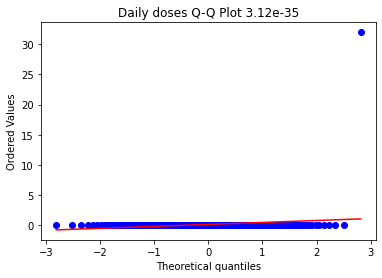

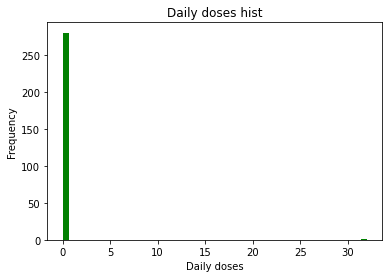

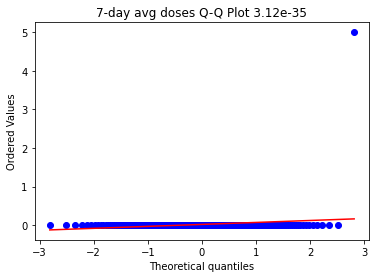

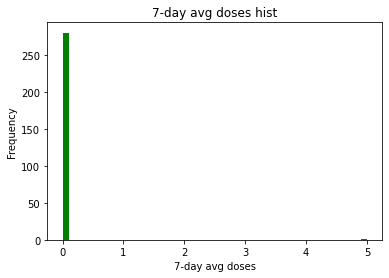

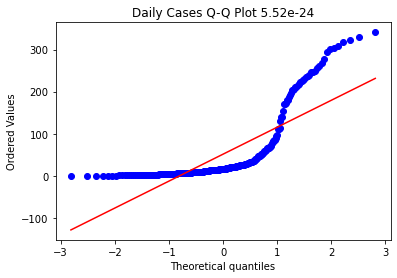

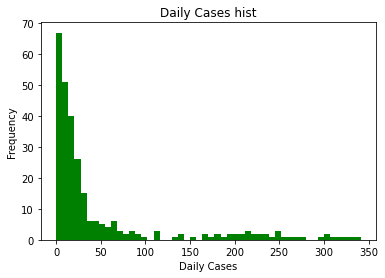

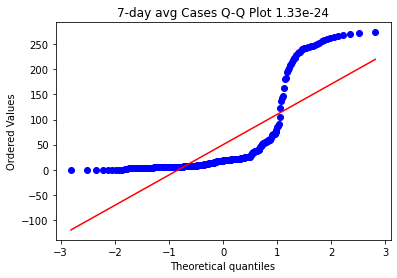

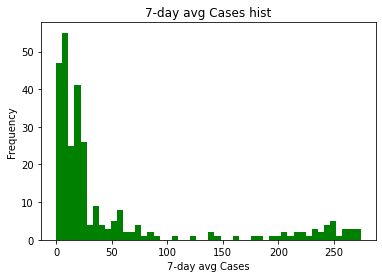

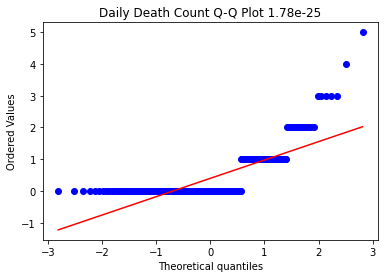

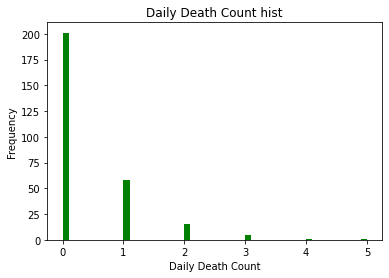

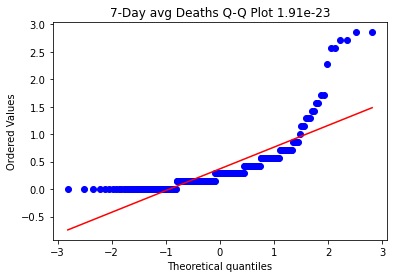

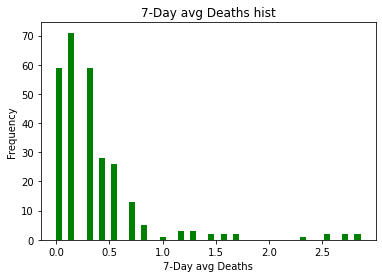

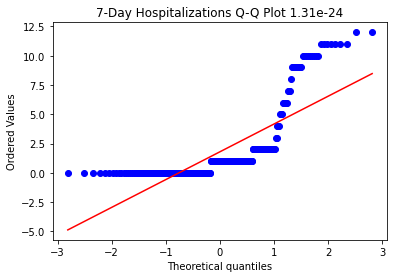

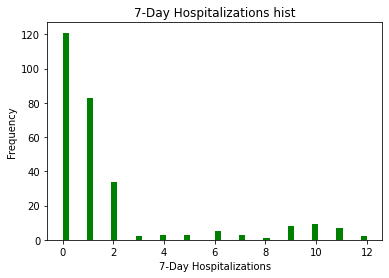

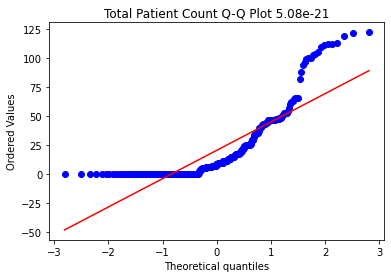

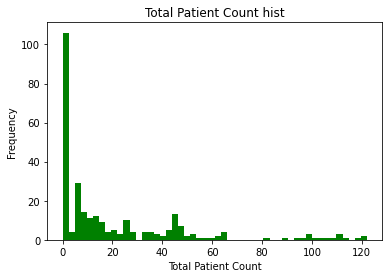

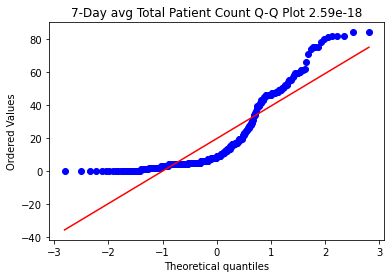

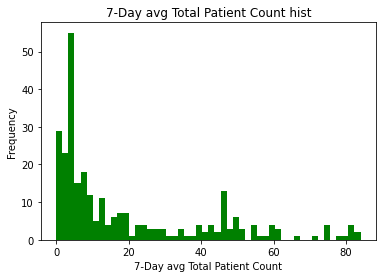

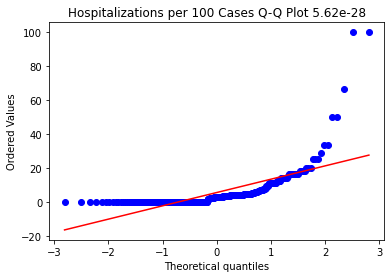

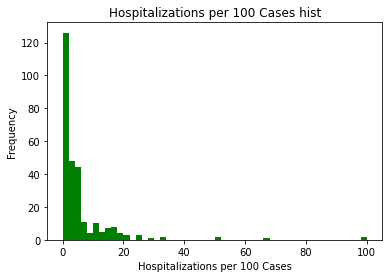

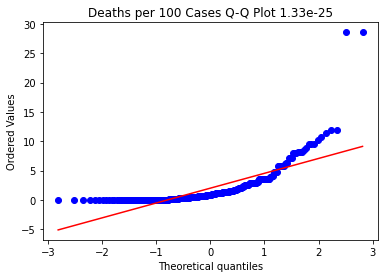

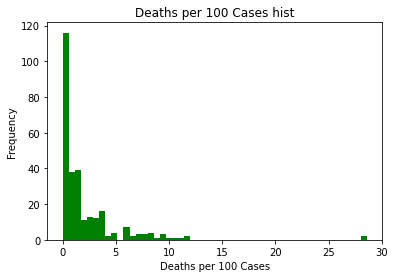

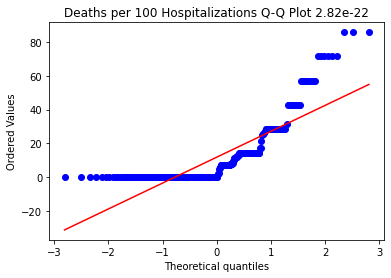

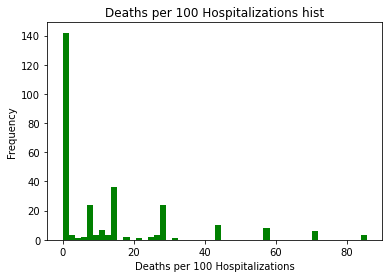

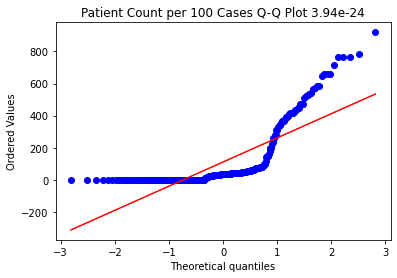

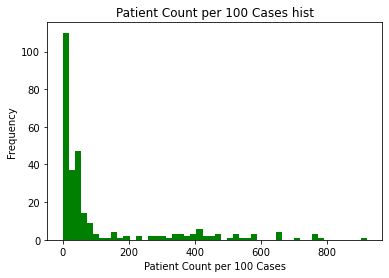

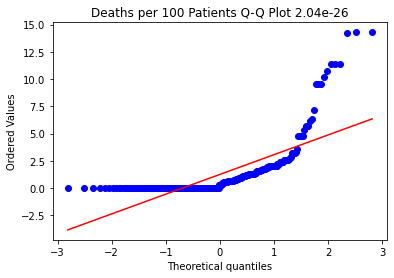

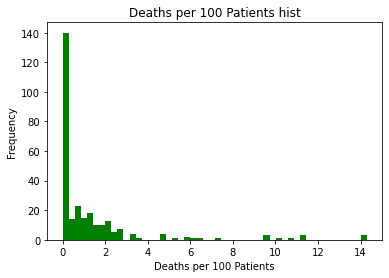

In [107]:
# loop through all the relevant columns and creata a qq plot and histogram for each one because I'm a madman.

for col in pre_group.columns[2:]:
    shapiro_stat = stats.shapiro(pre_group[col])
    stats.probplot(pre_group[col], dist="norm", plot= plt)
    plt.title("{col} Q-Q Plot {pvalue:.3}".format(col = col, pvalue=shapiro_stat.pvalue))
    # plt.savefig("{col} qqplot.png".format(col = col))
    plt.show()
    pre_group[col].plot(kind="hist", title= "{col} hist".format(col=col), color="green", bins=50)
    plt.xlabel("{col}".format(col=col))
    plt.show()


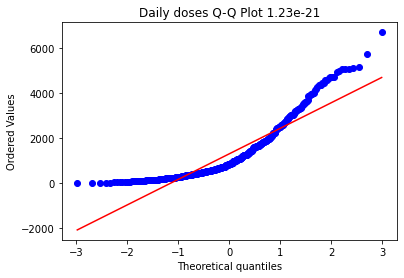

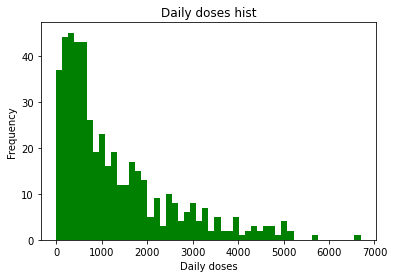

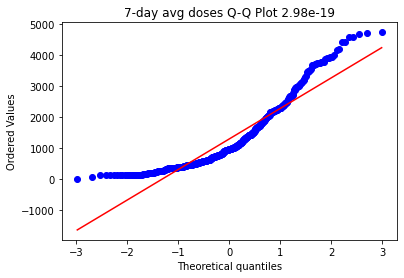

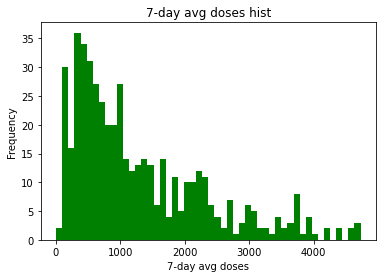

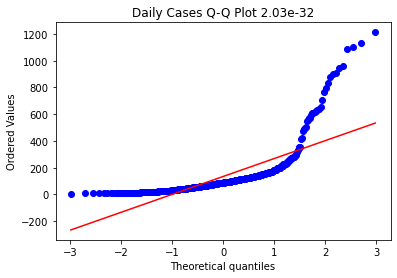

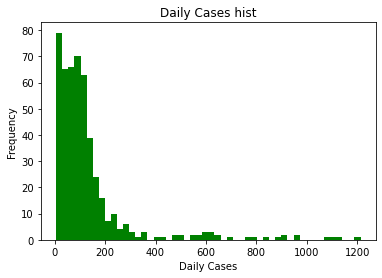

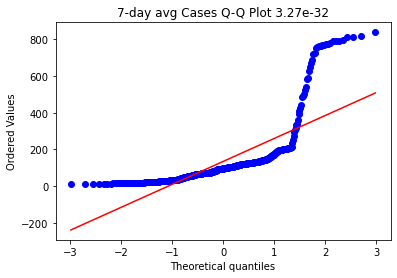

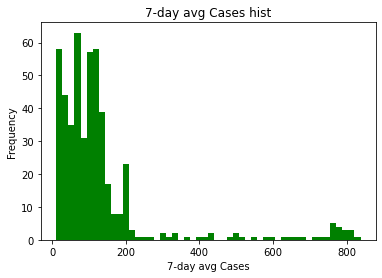

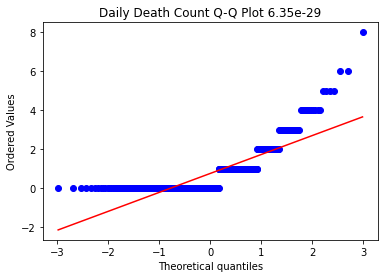

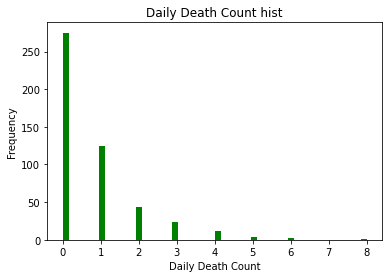

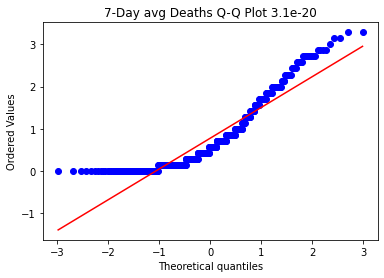

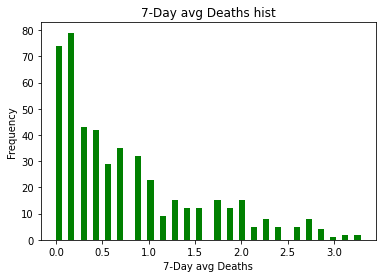

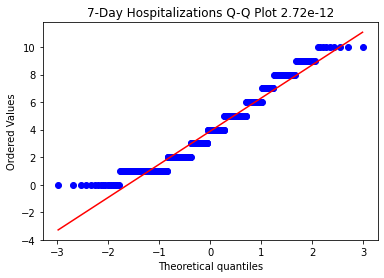

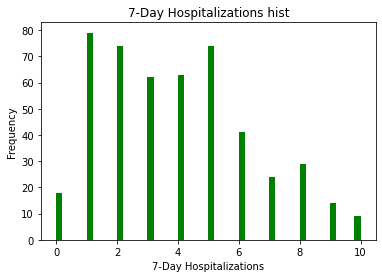

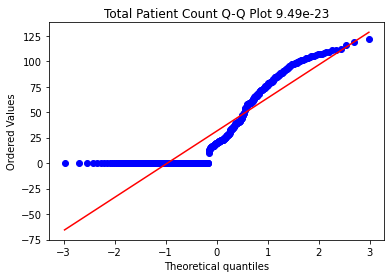

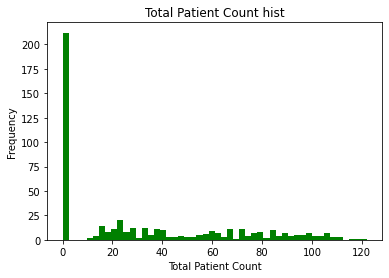

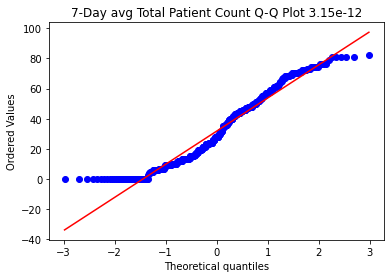

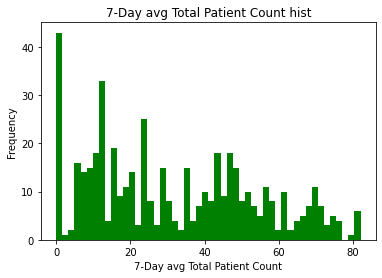

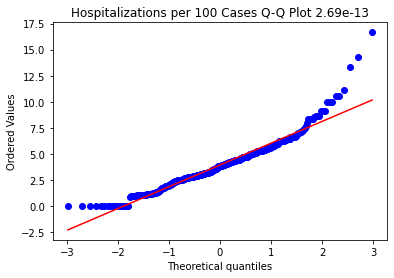

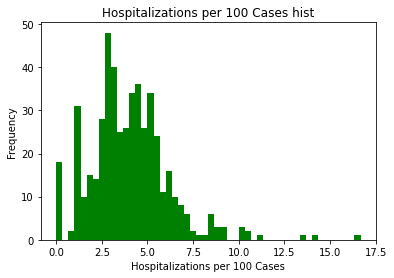

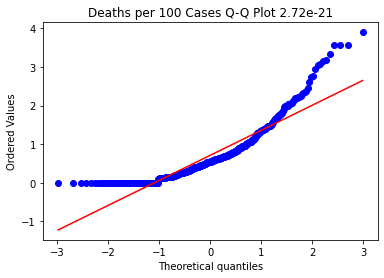

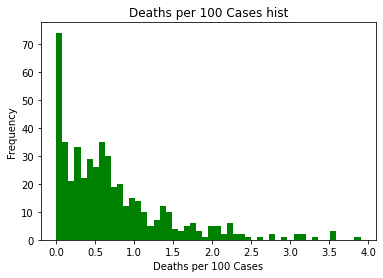

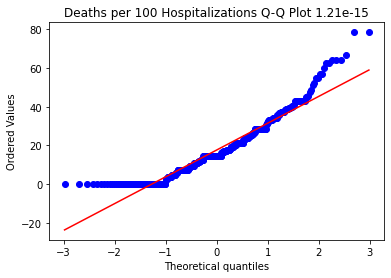

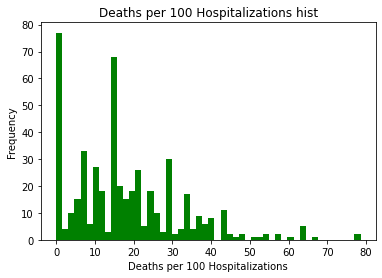

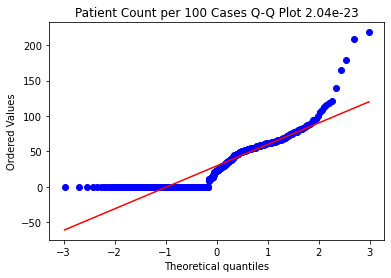

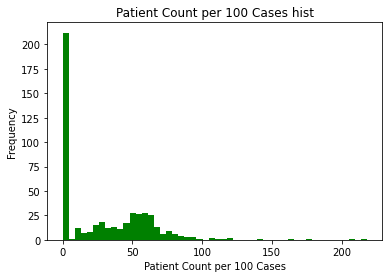

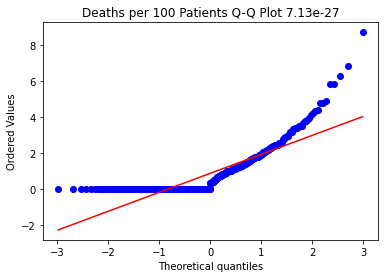

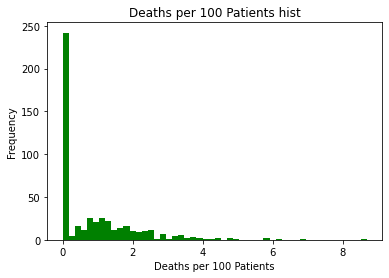

In [108]:
for col in post_group.columns[2:]:
    shapiro_stat = stats.shapiro(post_group[col])
    stats.probplot(post_group[col], dist="norm", plot= plt)
    plt.title("{col} Q-Q Plot {pvalue:.3}".format(col = col, pvalue=shapiro_stat.pvalue))
    # plt.savefig("{col} qqplot.png".format(col = col))
    plt.show()
    post_group[col].plot(kind="hist", title= "{col} hist".format(col=col), color="green", bins=50)
    plt.xlabel("{col}".format(col=col))
    plt.show()

In [109]:
basic_ttest = stats.ttest_ind(pre_group['Daily Cases'], post_group['Daily Cases'], equal_var=False)
print(basic_ttest)

Ttest_indResult(statistic=-8.941609699952151, pvalue=3.079108585299608e-18)


In [110]:
pre_group['Daily Cases']

0        1
1        0
2        0
3        0
4        0
      ... 
276    203
277    228
278    139
279     95
280    111
Name: Daily Cases, Length: 281, dtype: int64

In [111]:
pre_group.columns[4]

'Daily Cases'

In [112]:
# basic_ttest_idex = stats.ttest_ind(pre_group.columns[4], post_group.columns[4], equal_var=False)
# print(basic_ttest_idex)

In [113]:
# for cols1, cols2 in (pre_group.columns[2:], post_group.columns[2:]): 
#     t_test = stats.ttest_ind(cols1, cols2, equal_var=False)
#     print(t_test)

In [114]:
#zip = zip(pre_group.columns[2:],(post_group.columns[2:]))
